In [77]:
import pandas as pd
import numpy as np

%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

AgentType = ["poorHigh","poorLow","richHigh","richLow"]
Beta_r = [0.02,0.04,0.06,0.08,0.10]
Gamma = [4.0, 4.5, 5.0, 5.5, 6.0]

Populating the interactive namespace from numpy and matplotlib


/home/dli36/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['title', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [78]:
import jax.numpy as jnp
T_max = 60
T_min = 0
# variable associated with housing and mortgage 
# age limit of buying a house
ageLimit = 30
mortgageLength = 30
# relative importance of housing consumption and non-durable consumption 
alpha = 0.6
# mortgage rate 
rh = 0.045
# housing unit
H = 1000
# max rent unit
Rl = 500
# housing price constant 
pt = 2*250/1000
# 30k rent 1000 sf
pr = 2*10/1000 * 2 
# constant cost 
c_h = 5
c_s = H*pt*0.4
# Dm is used to update the mortgage payment
Dm = [(1+rh) - rh*(1+rh)**(T_max - t)/((1+rh)**(T_max-t)-1) for t in range(T_min, T_max)]
Dm[-1] = 0
Dm = jnp.array(Dm)
# 30 year mortgage
Ms = []
M = H*pt*0.8
m = M*(1+rh) - Dm[30]*M
for i in range(30, T_max):
    Ms.append(M)
    M = M*(1+rh) - m
Ms.append(0)
Ms = jnp.array(Ms)
pr = 2*10/1000 * 2 

# get the empirical part ready
Fdf = pd.read_csv("family/familyData.csv")
codes = {'employed':1, 'unemployed': 0, "retired": 0}
Fdf["employmentStatus"] = Fdf["employmentStatus"].map(codes)
codes = {'owner':1, 'renter': 0}
Fdf["ownership"] = Fdf["ownership"].map(codes)
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]

# annual amount
laborIncome = []
wealthLevel = []
consumption = []
investmentStock = []
bondOrcash = []
annuityAmount = []
participation_mean = []
ownershipStatus_mean = []
employment_mean = []

for year in years:
    df = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]
    laborIncome.append(df["laborIncome"].values)
    investmentStock.append(df["investmentAmount"].values)
    consumption.append(df["totalExpense"].values)
    bondOrcash.append(df["liquidWealth"].values)
    participation_mean.append(df["participation"].mean())
    ownershipStatus_mean.append(df["ownership"].mean())
    employment_mean.append(df["employmentStatus"].mean())
    
# target first moments
consumption_mean = np.array([c.mean() for c in consumption])
investmentStock_mean = np.array([k.mean() for k in investmentStock])
bondOrcash_mean = np.array([b.mean() for b in bondOrcash])
annuityAmount_mean = np.array([n.mean for n in annuityAmount])
wealthLevel_mean = np.array([w.mean() for w in wealthLevel])
laborIncome_mean = np.array([l.mean() for l in laborIncome])
liquidWealth_mean = np.array([ll.mean() for ll in np.array(bondOrcash) + np.array(investmentStock)])


def outputVariables(waseozcbkhmType):
    output = []
    for i in range(waseozcbkhmType[0].shape[0]):
        output.append(np.concatenate((waseozcbkhmType[0][i],waseozcbkhmType[1][i],waseozcbkhmType[2][i],waseozcbkhmType[3][i]), axis = 1))
    return output


def variables(gamma, beta_r):
    waseozcbkhmType = []
    for agentType in AgentType:
        ### load in the data 
        fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
        waseozcbkhmType.append(np.load("solution/waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
    waseozcbkhm = outputVariables(waseozcbkhmType)
    # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
    wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
    return wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm 

/tmp/ipykernel_1342702/932566828.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  liquidWealth_mean = np.array([ll.mean() for ll in np.array(bondOrcash) + np.array(investmentStock)])


/tmp/ipykernel_1342702/3874769241.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


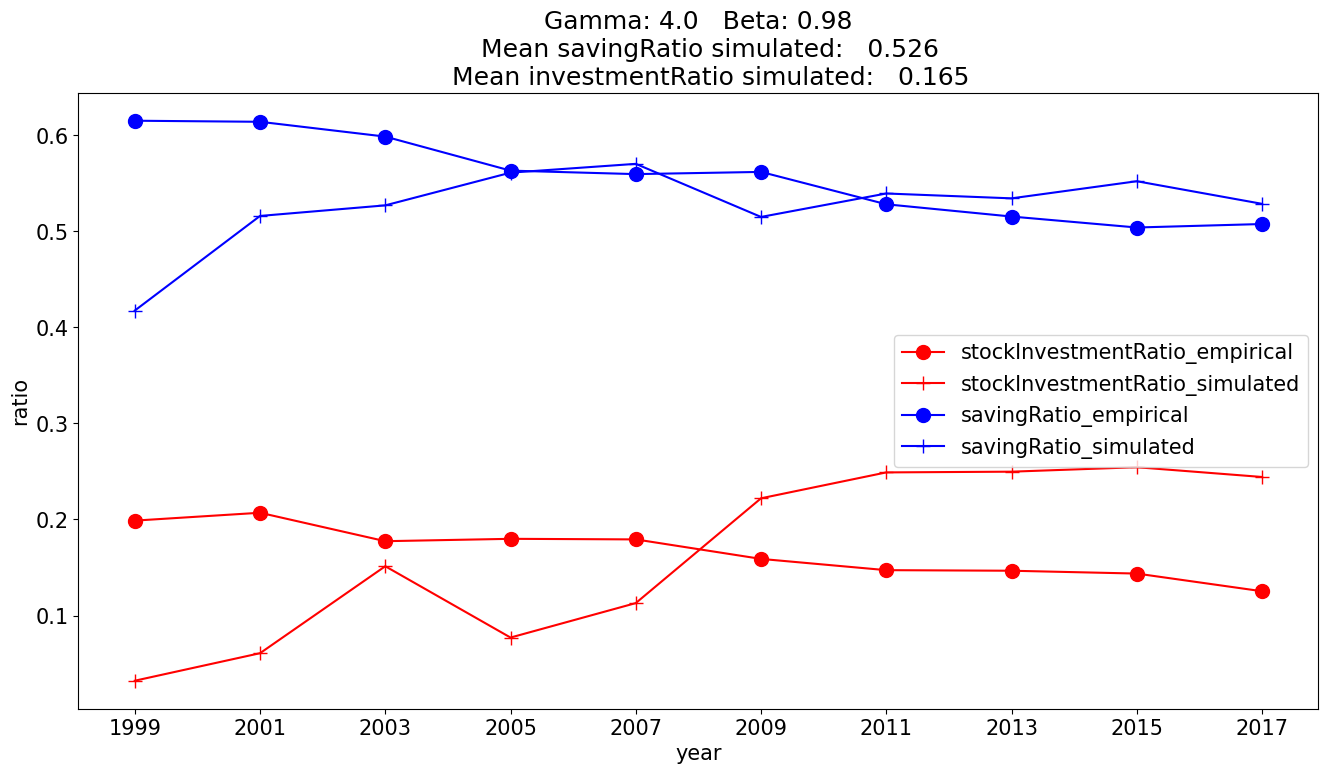

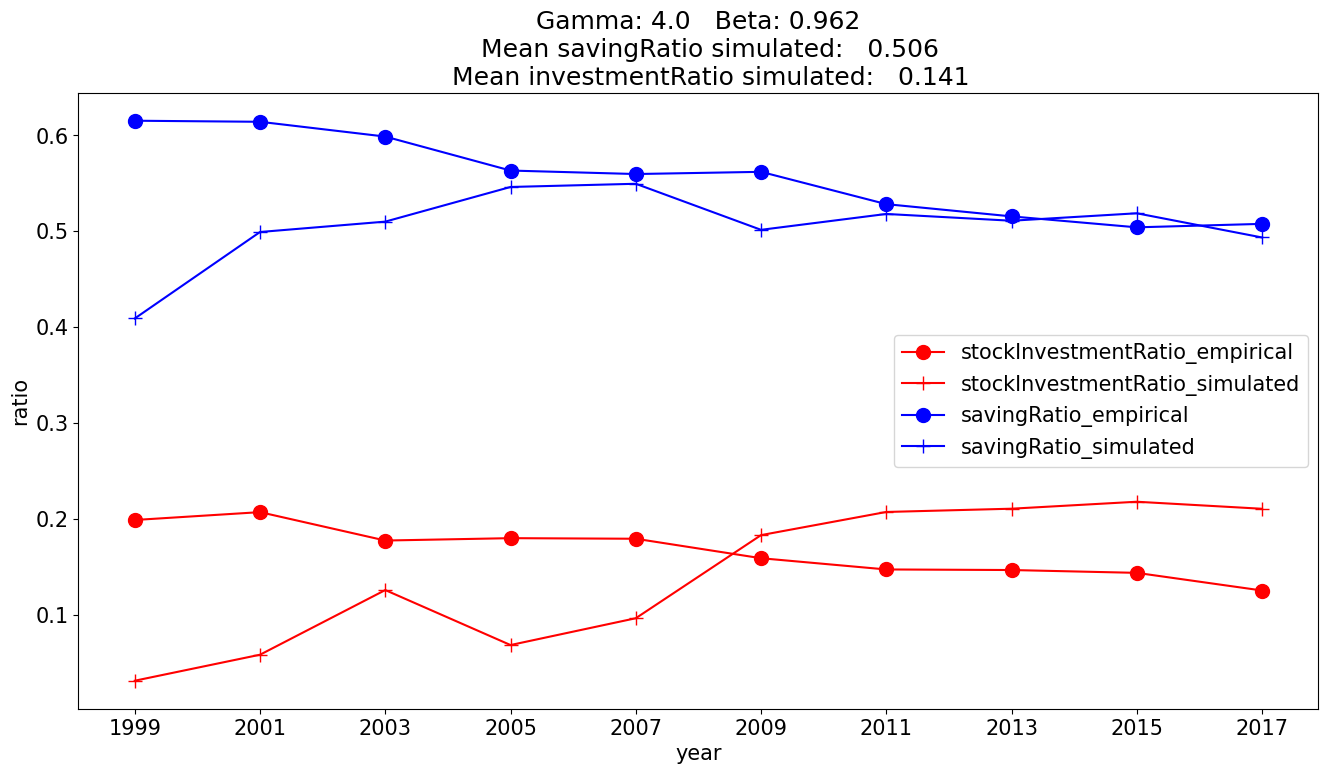

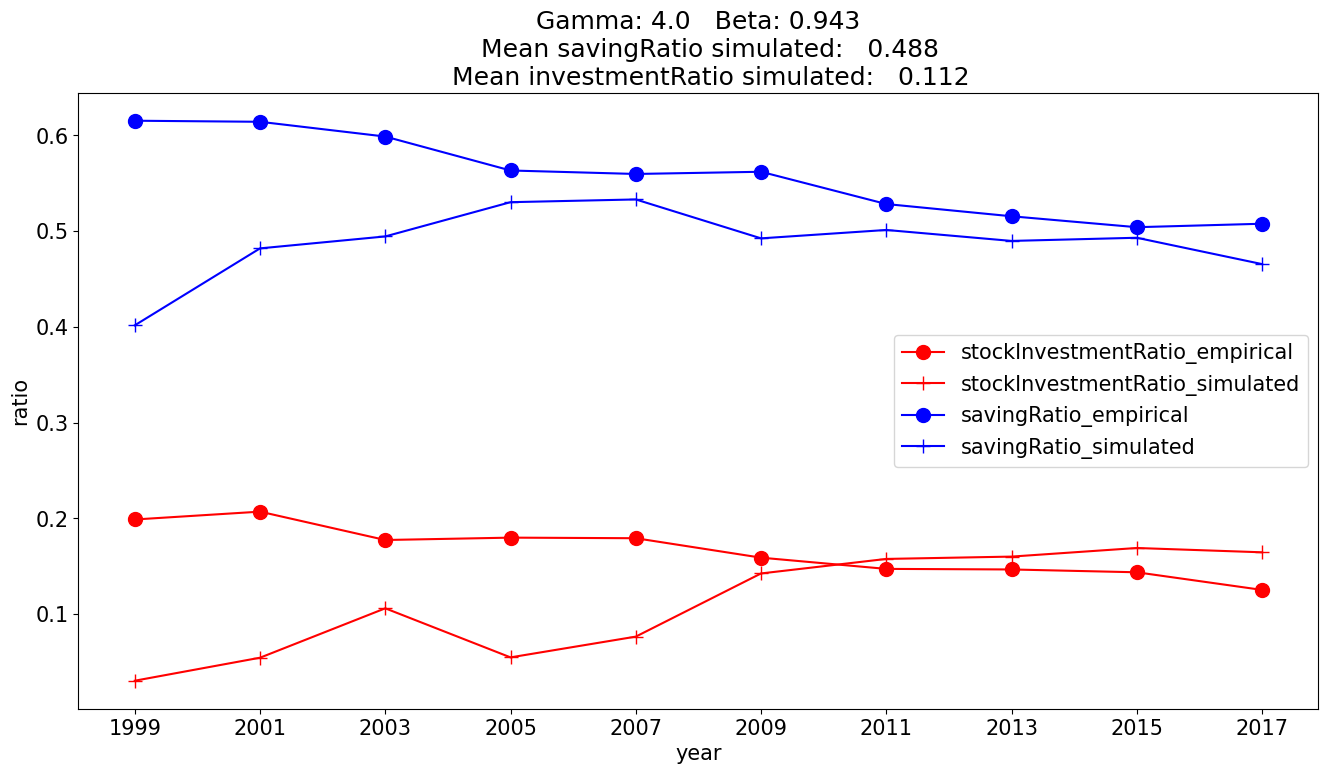

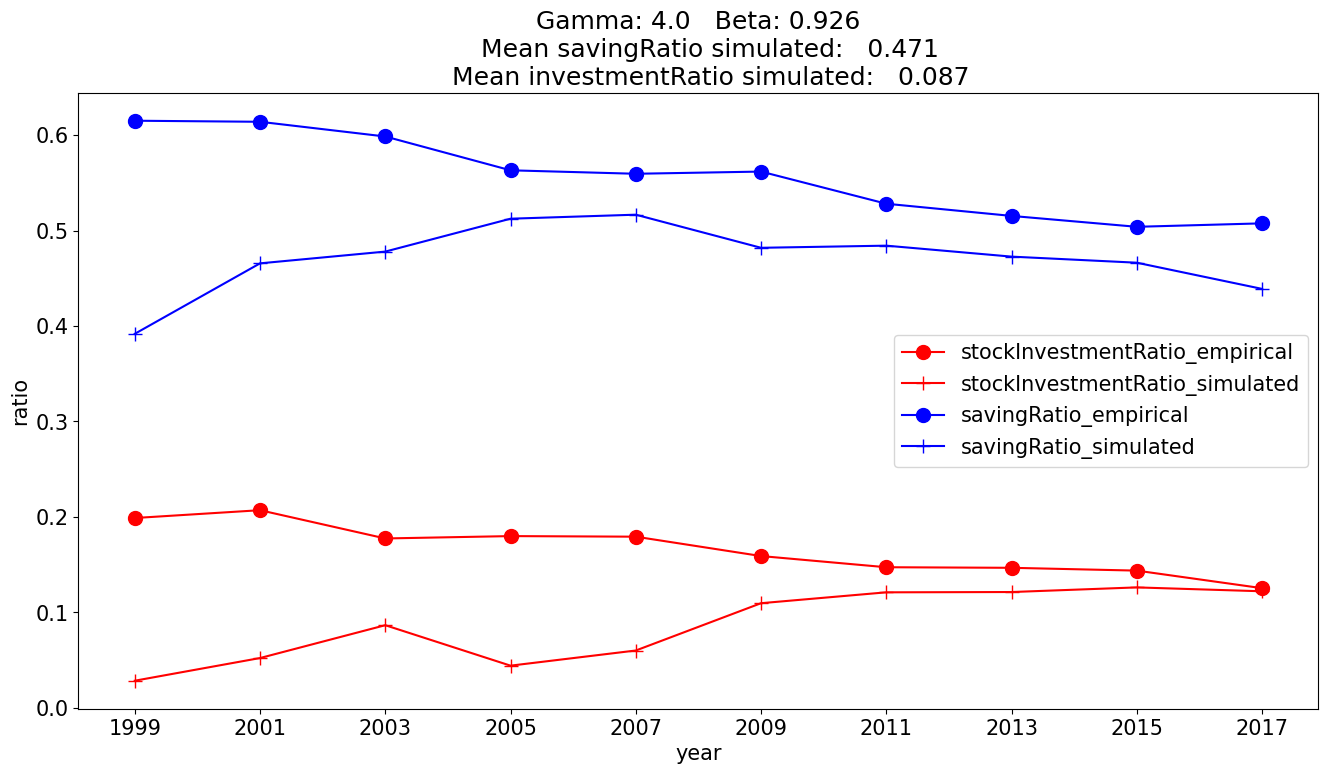

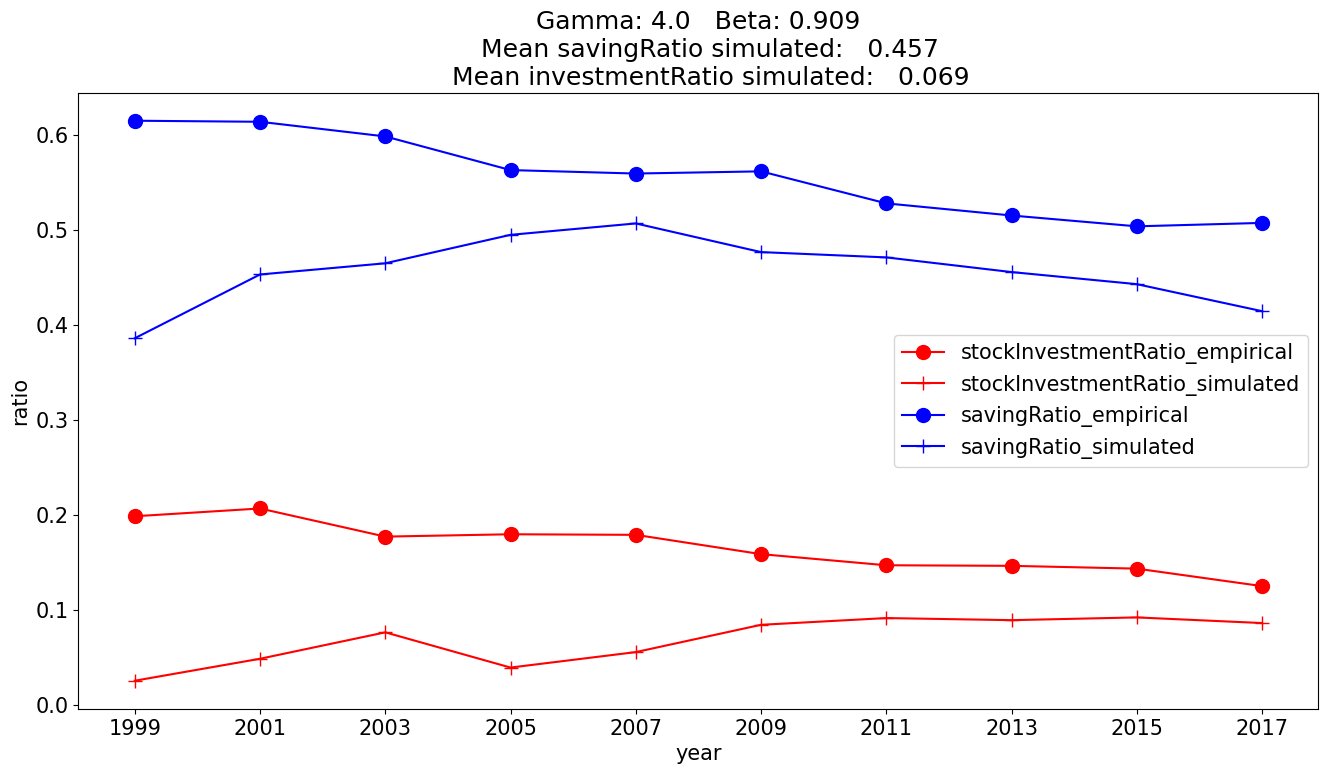

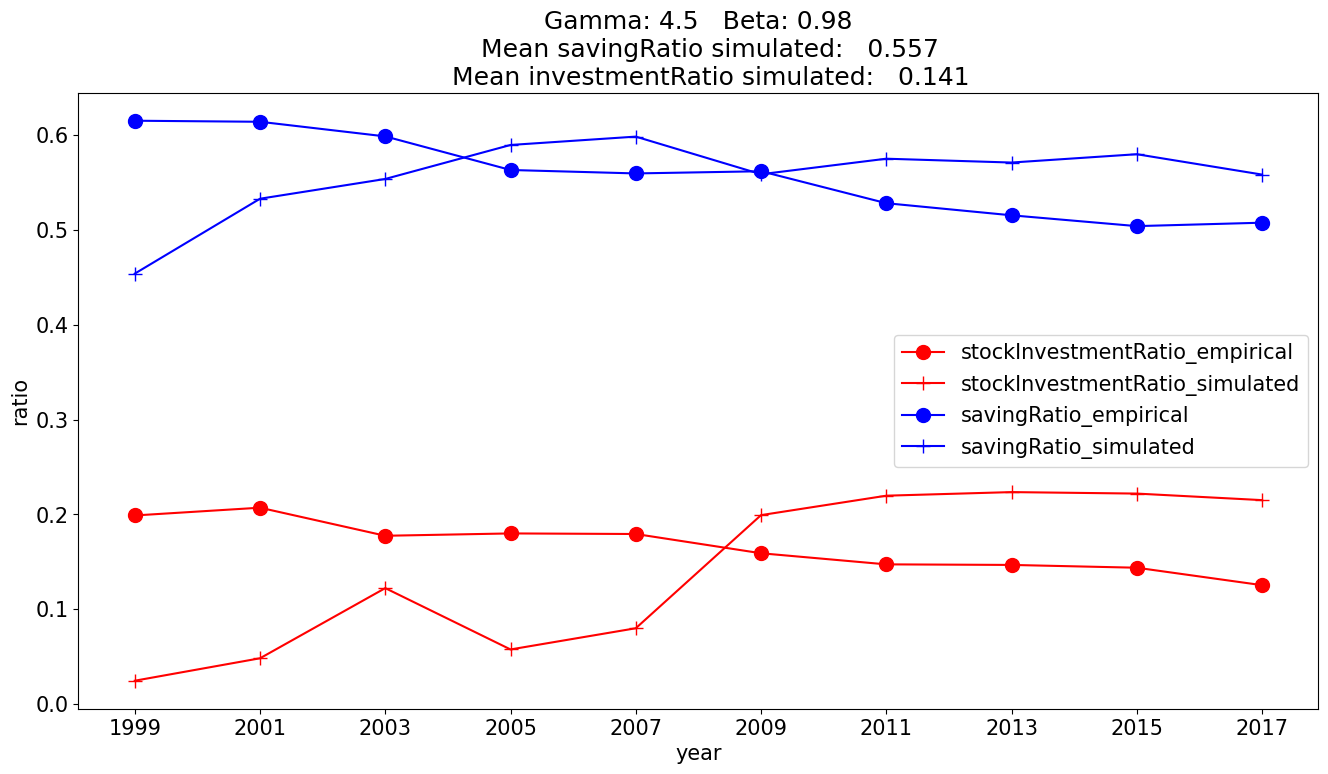

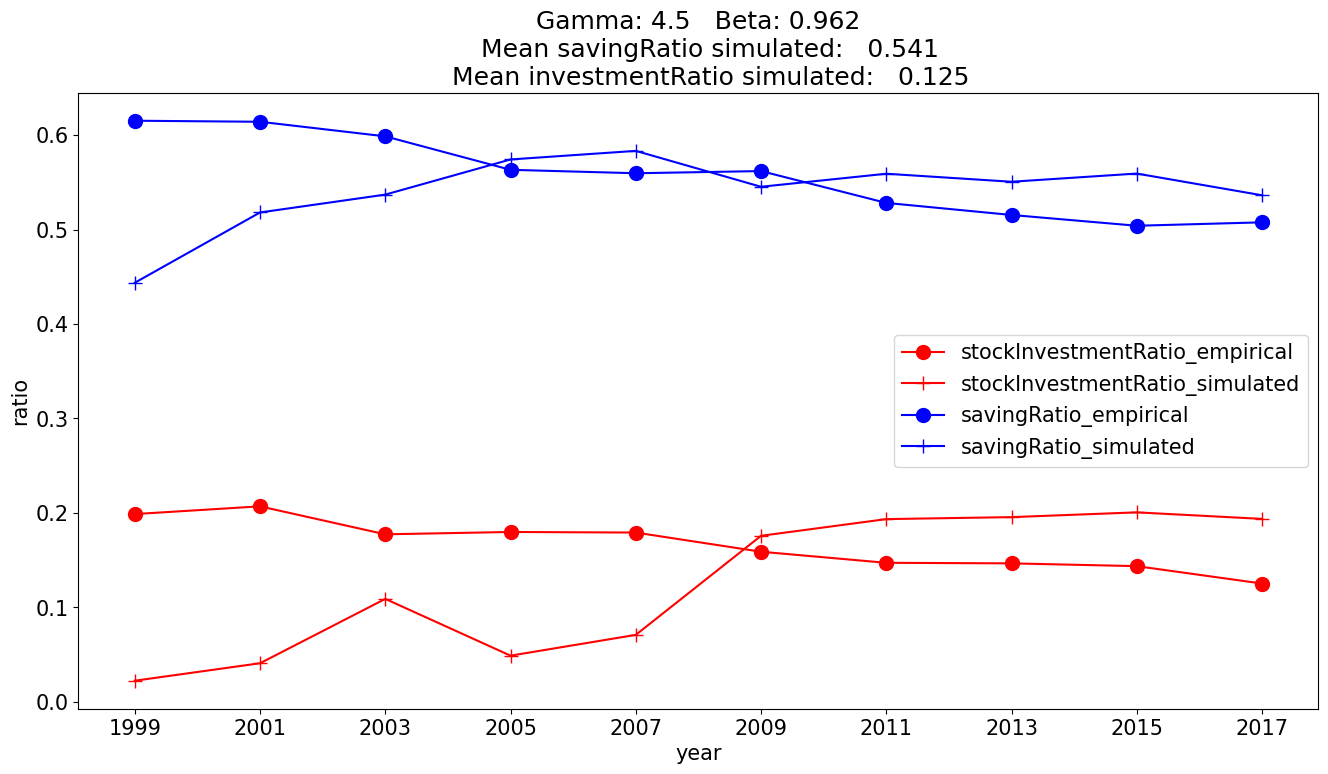

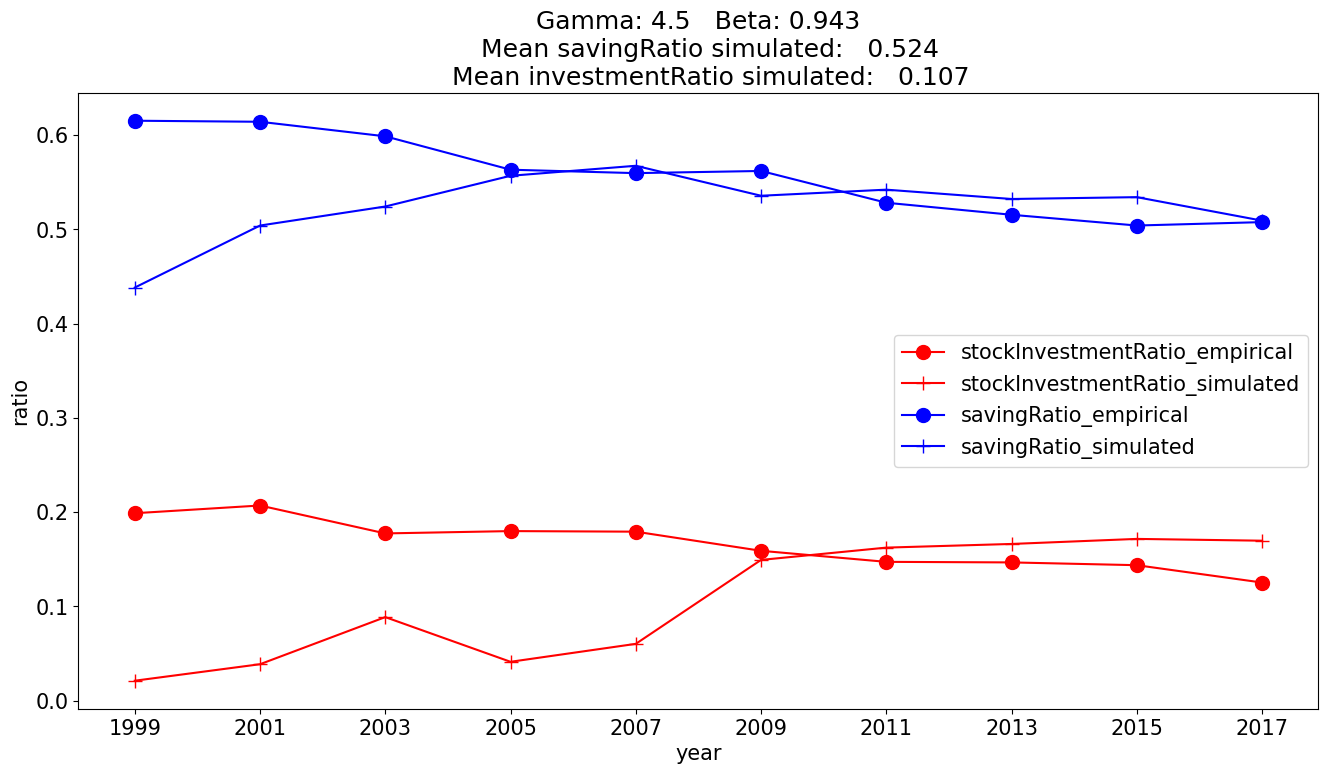

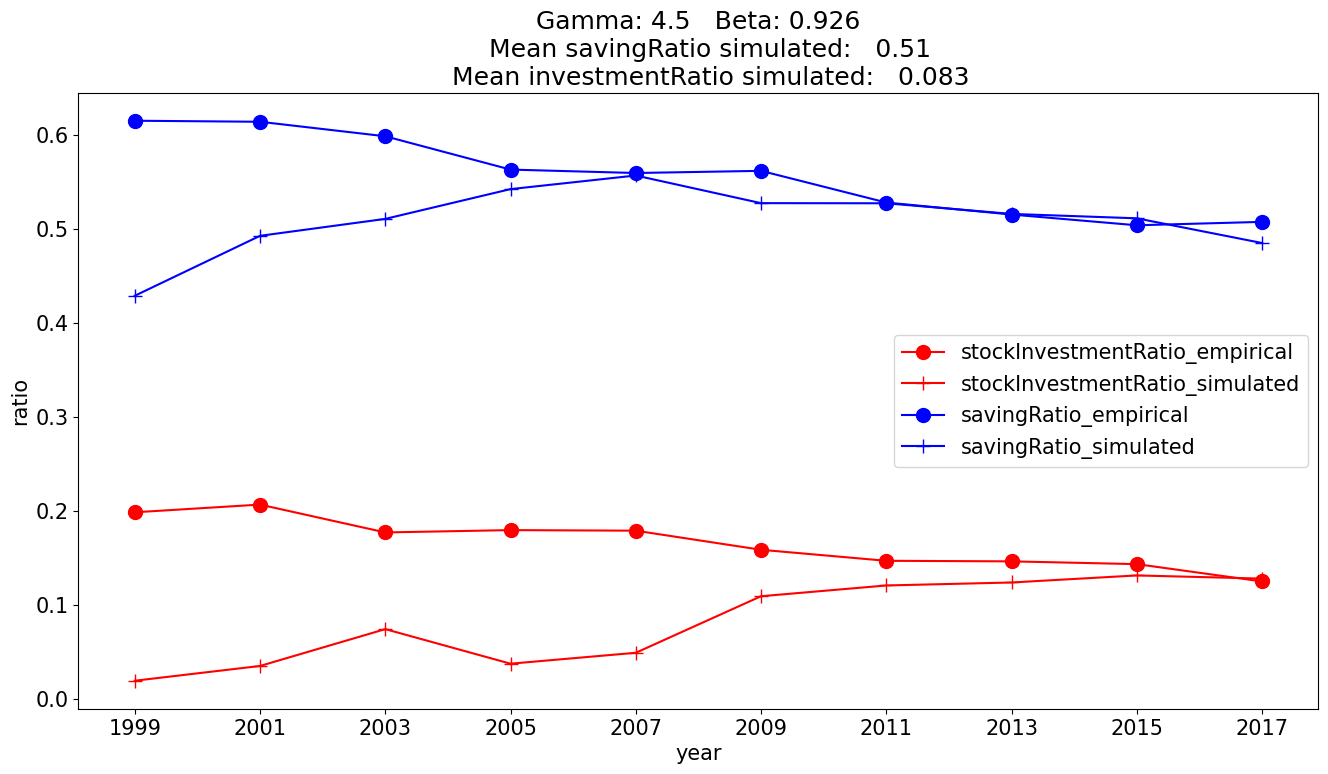

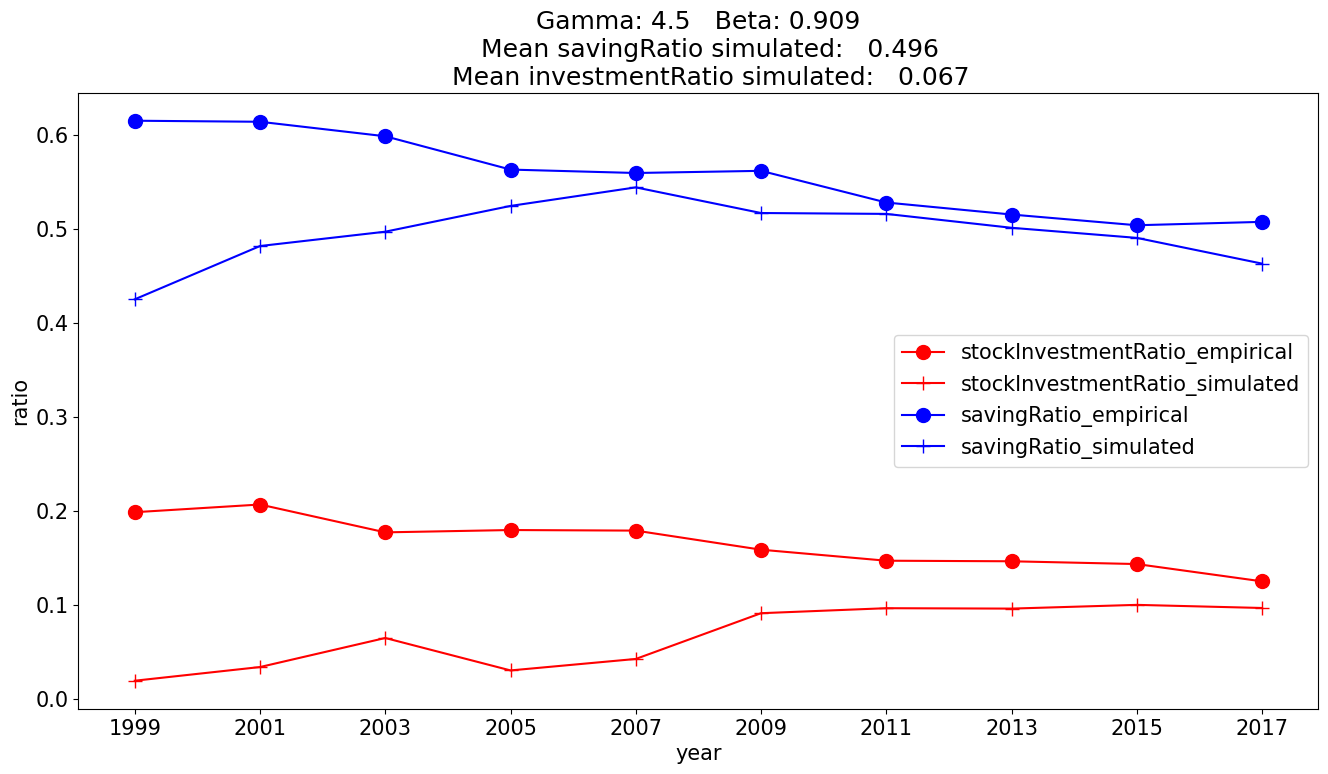

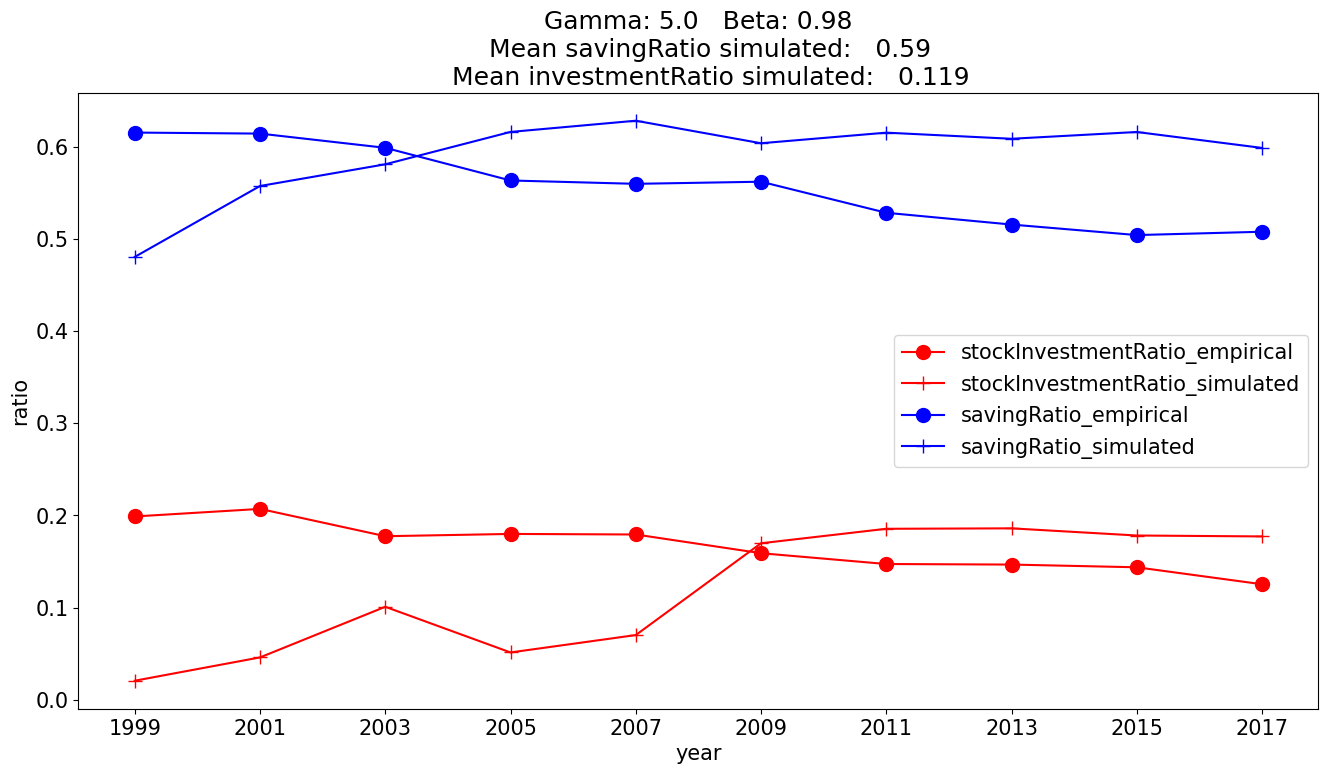

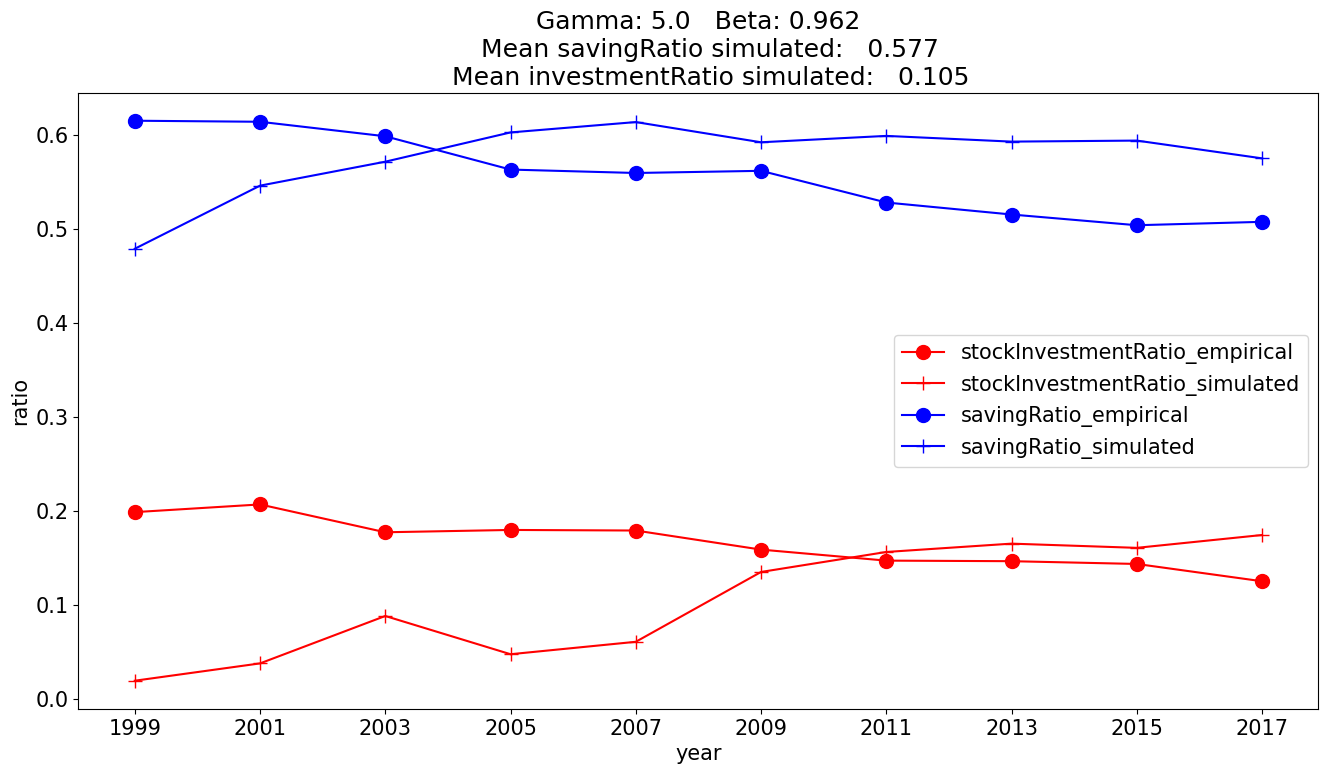

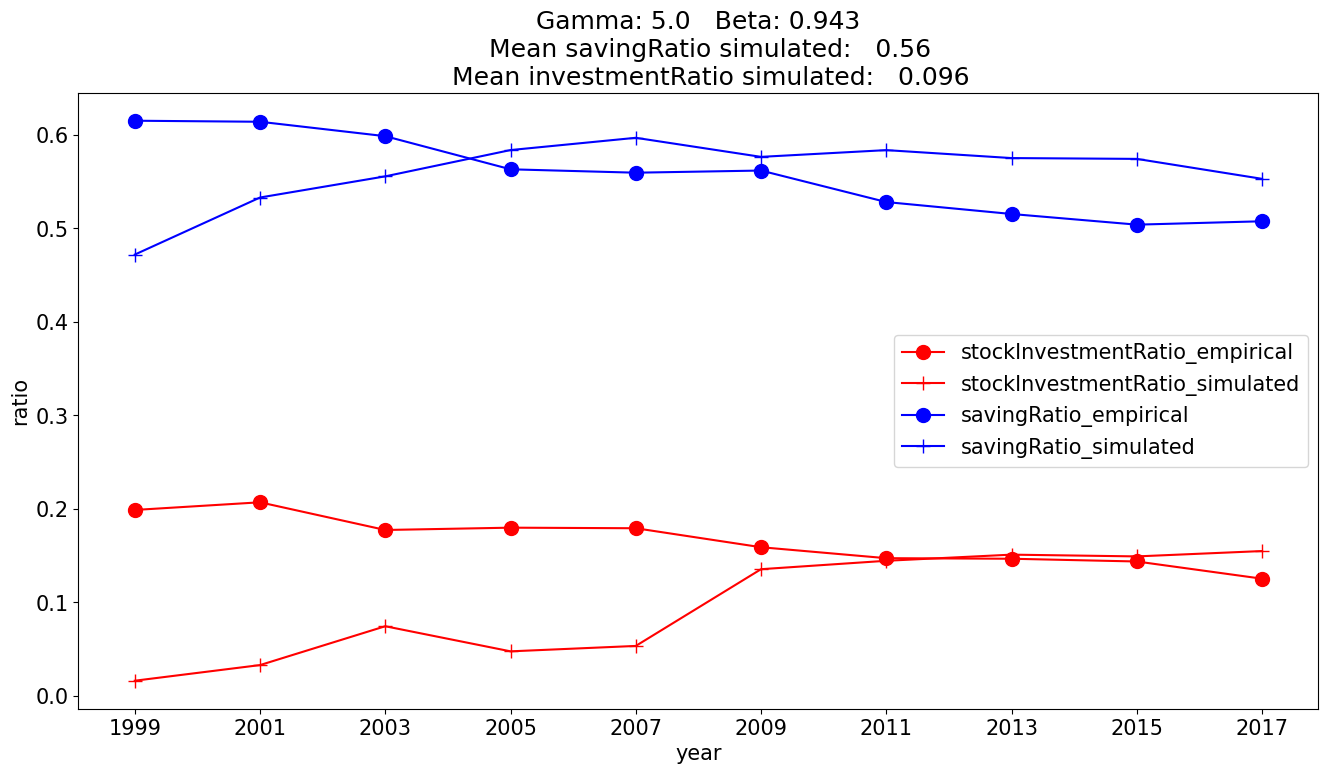

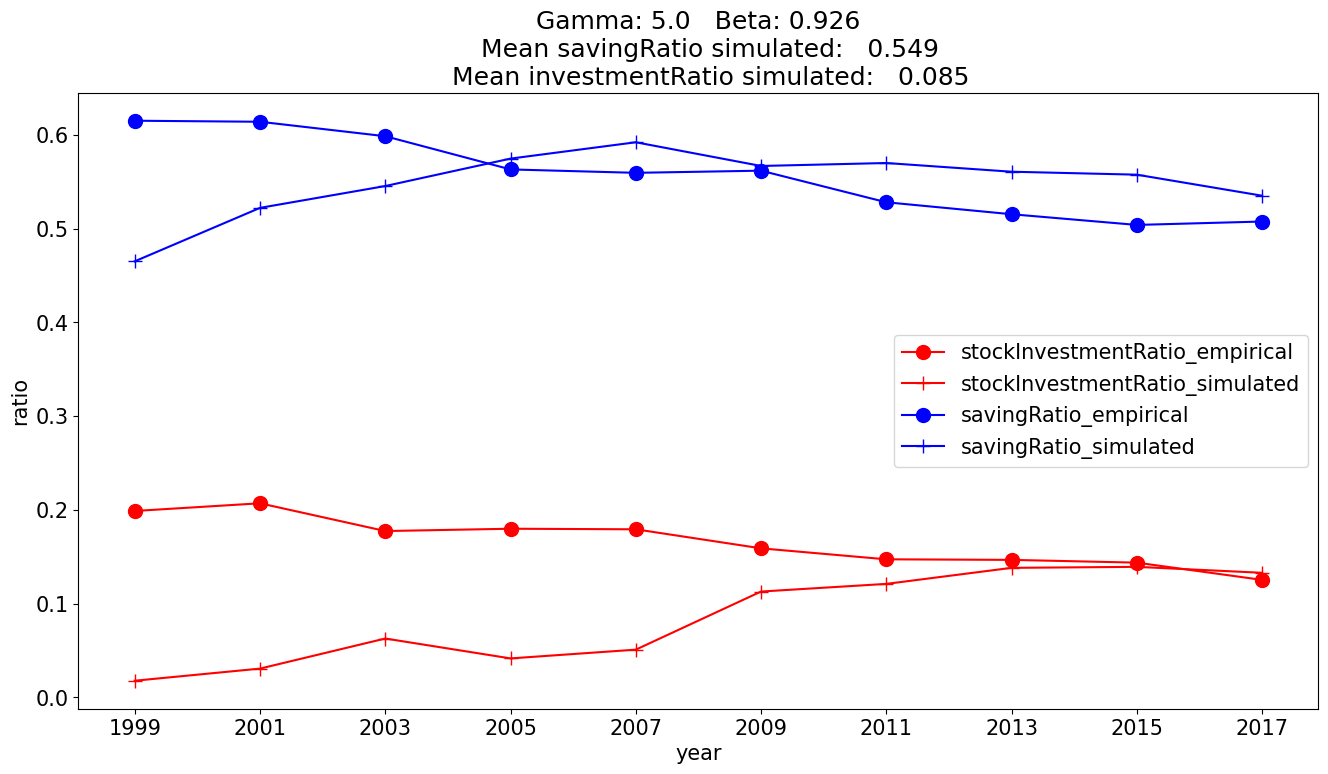

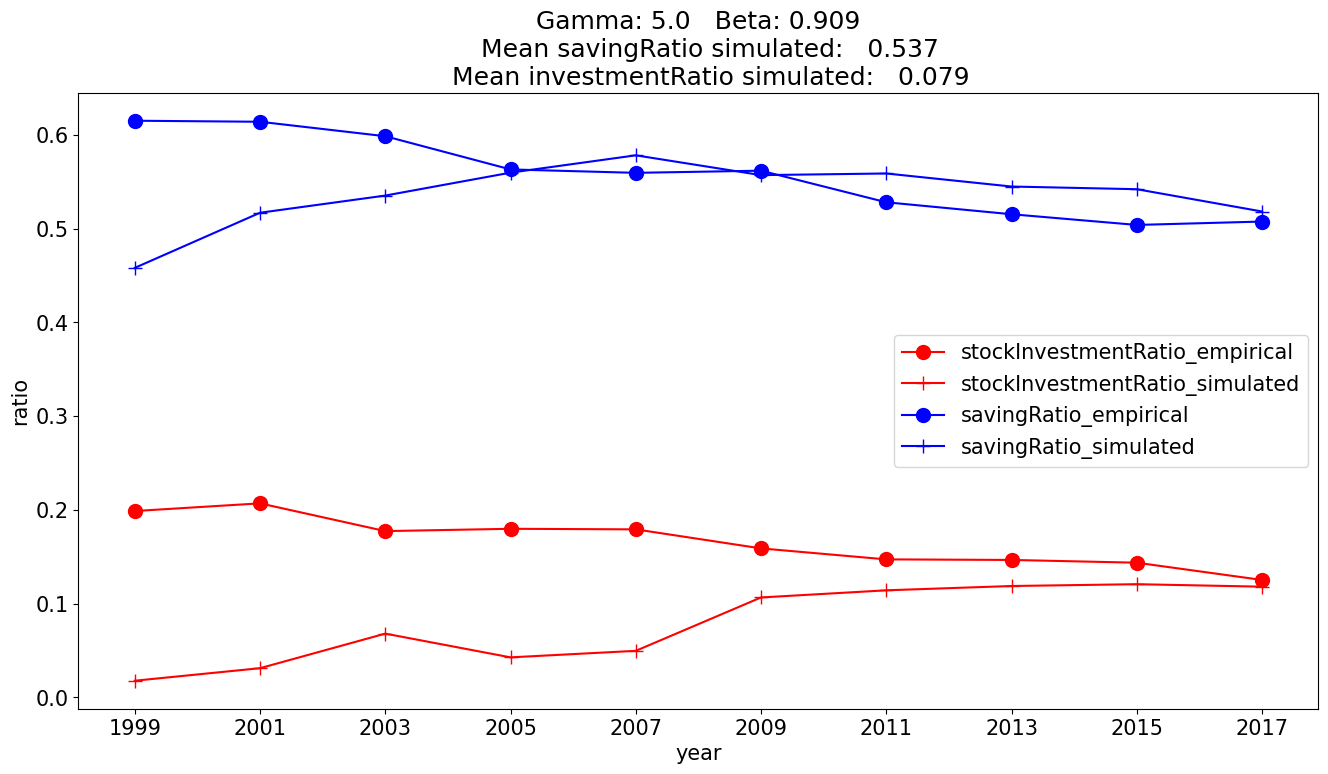

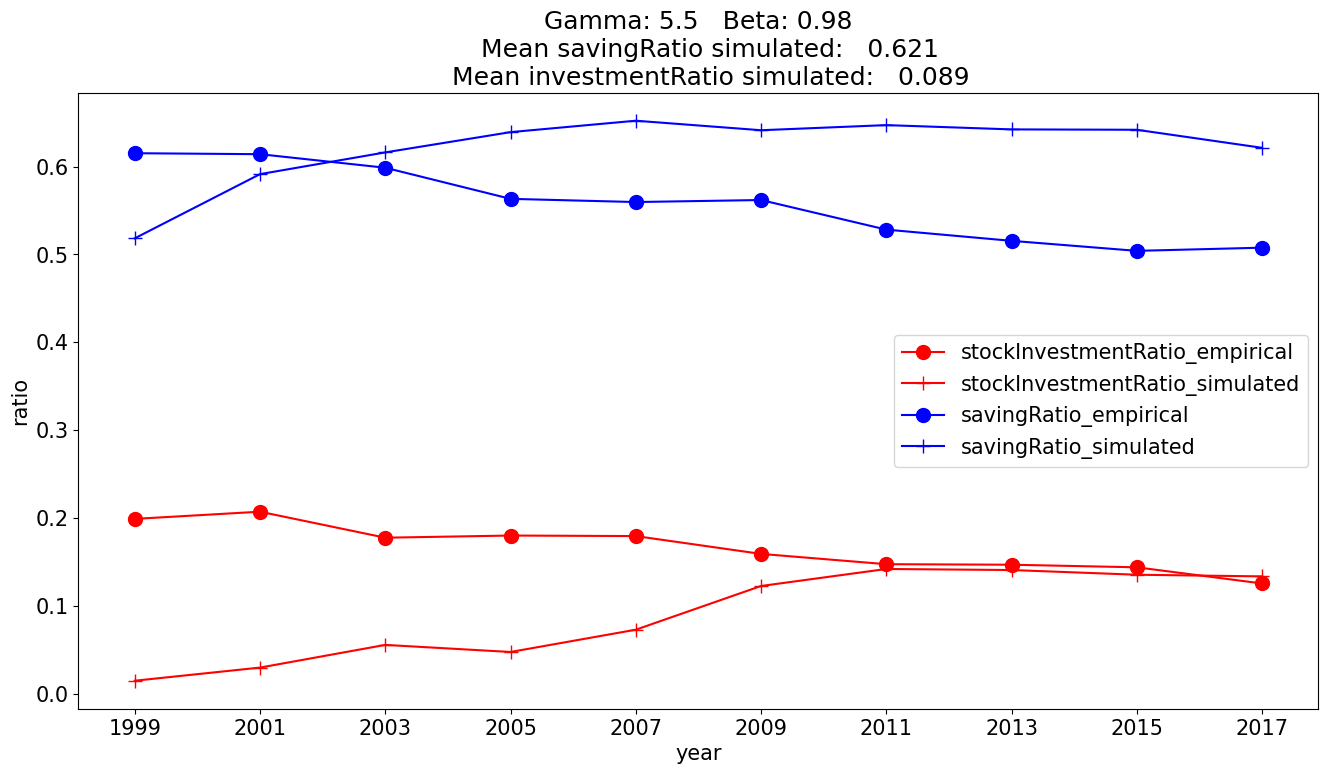

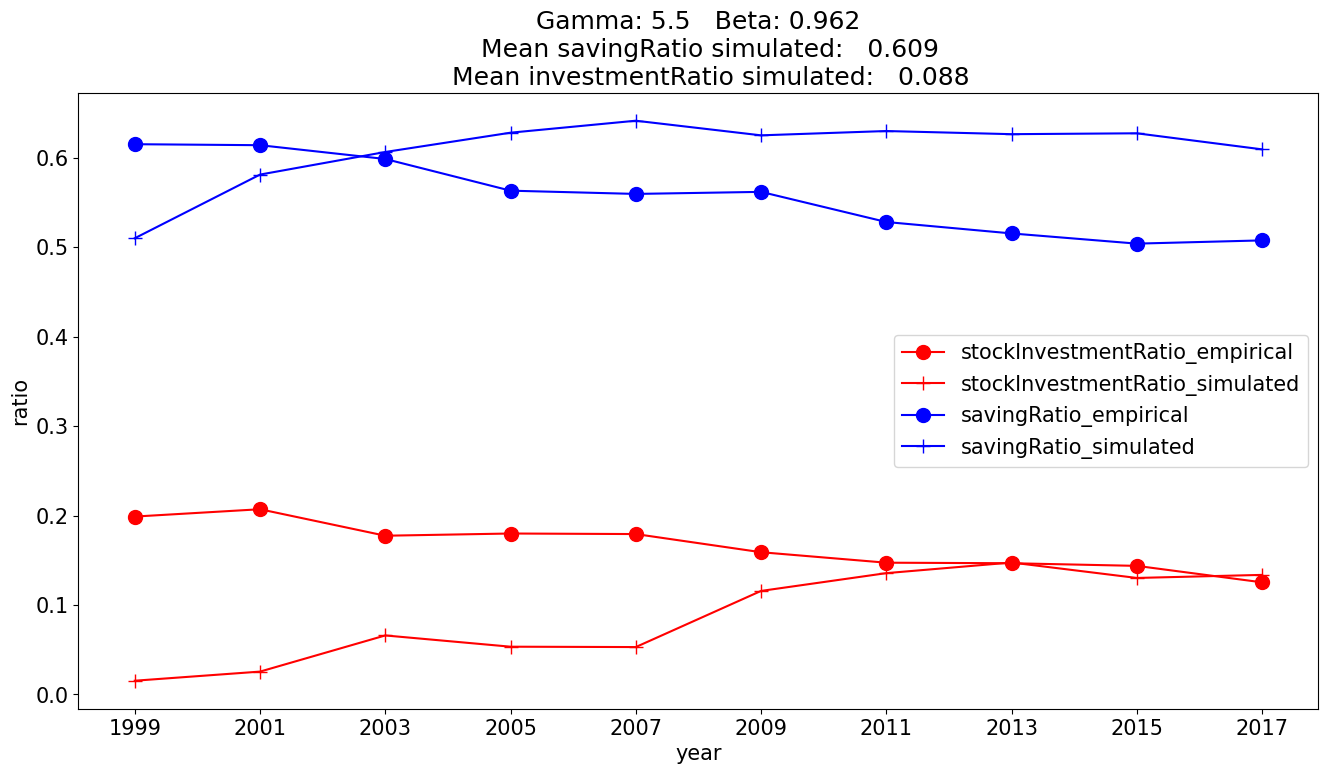

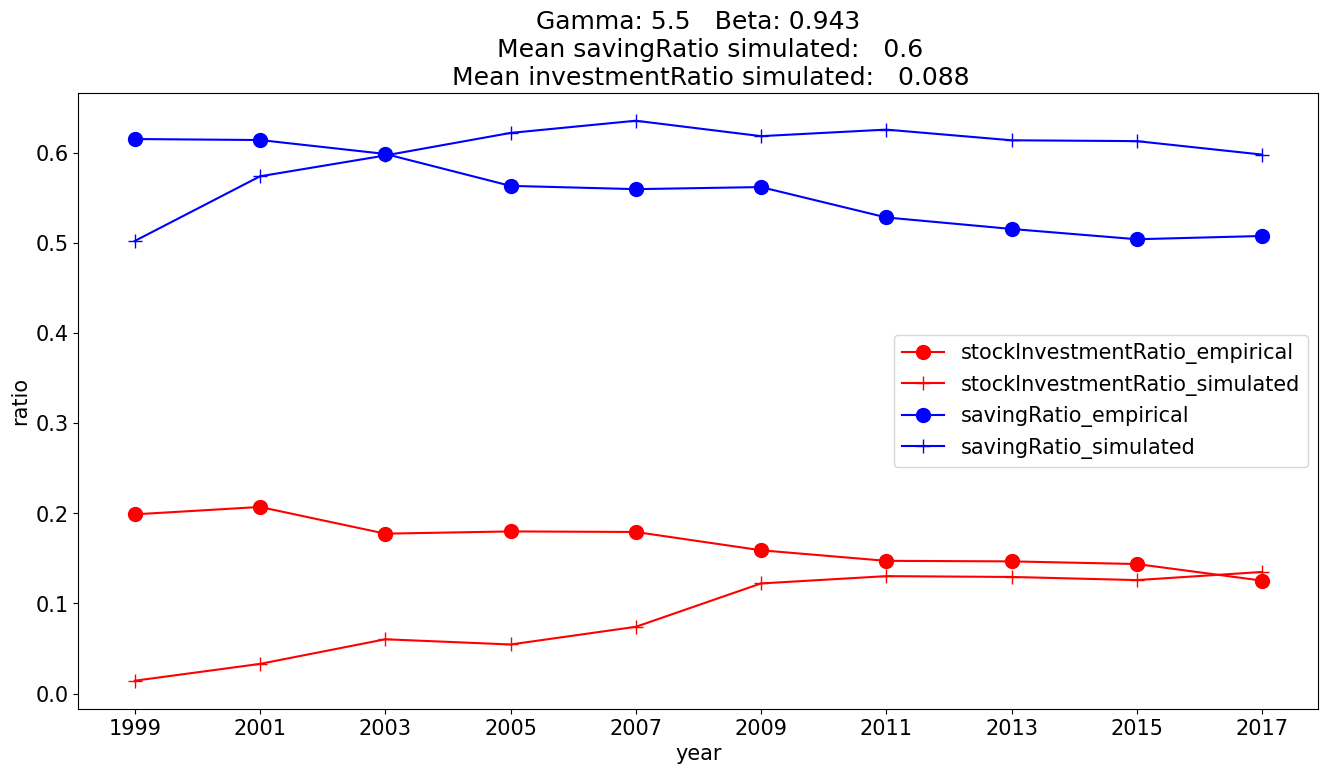

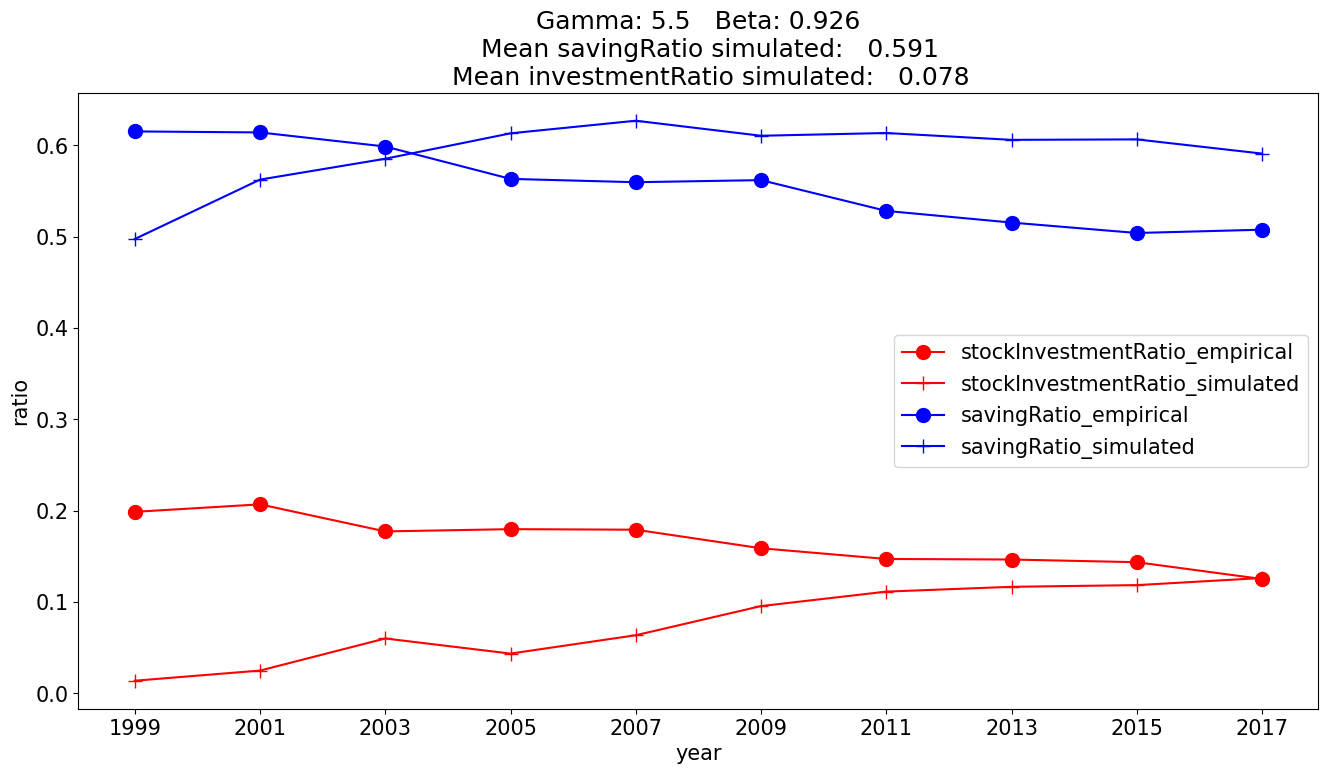

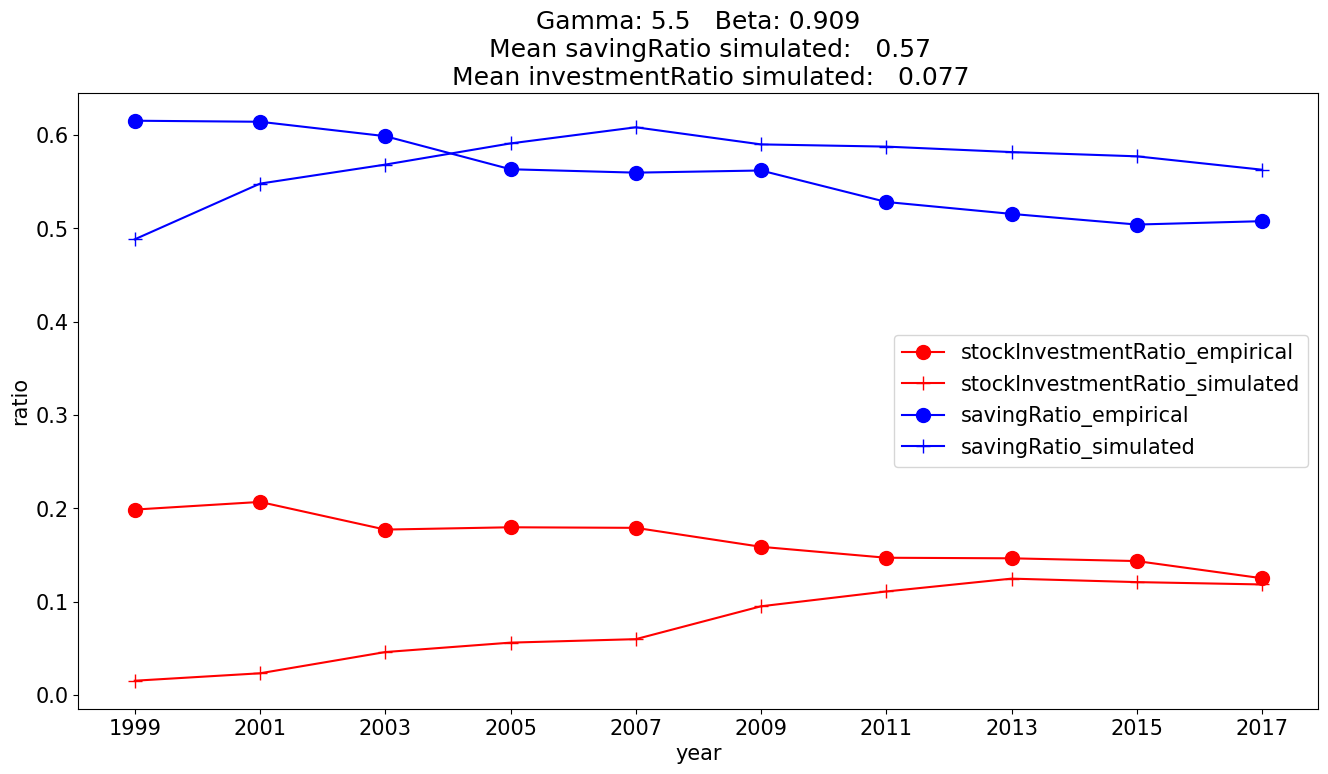

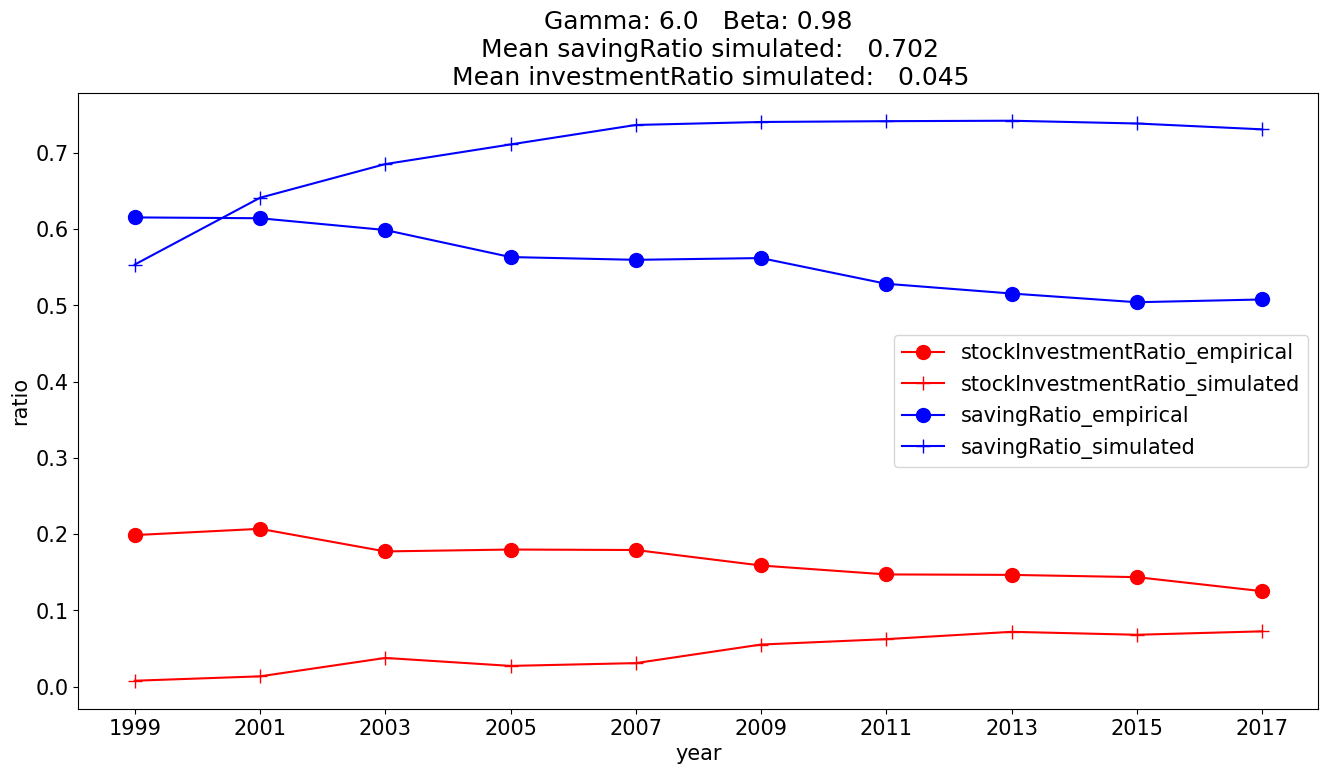

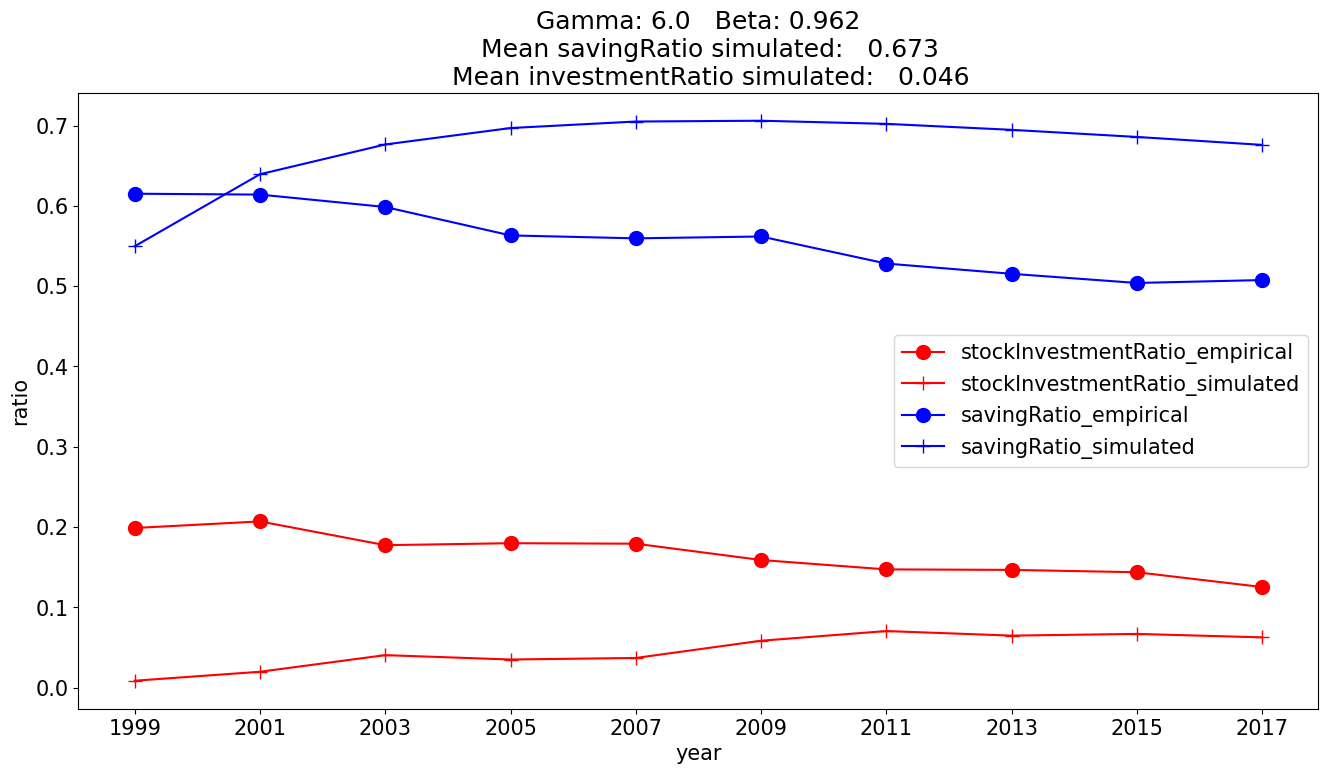

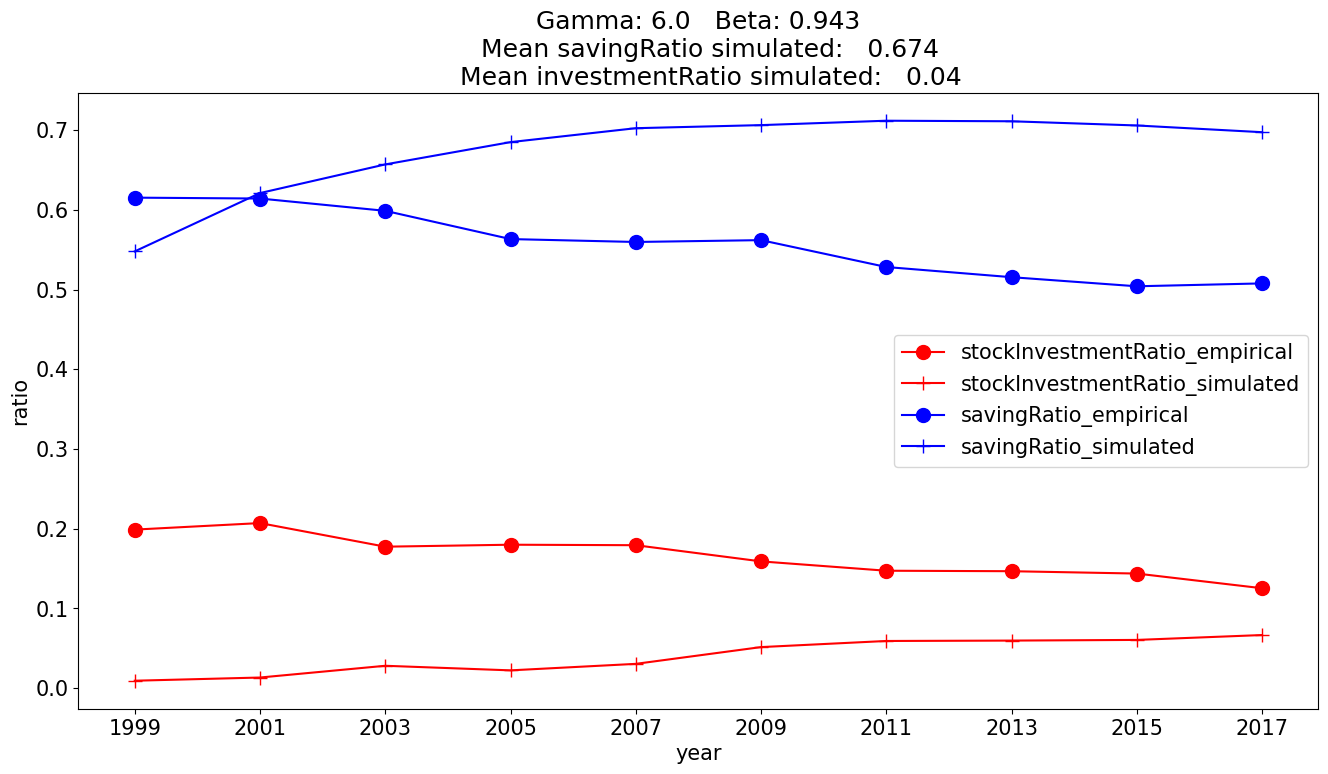

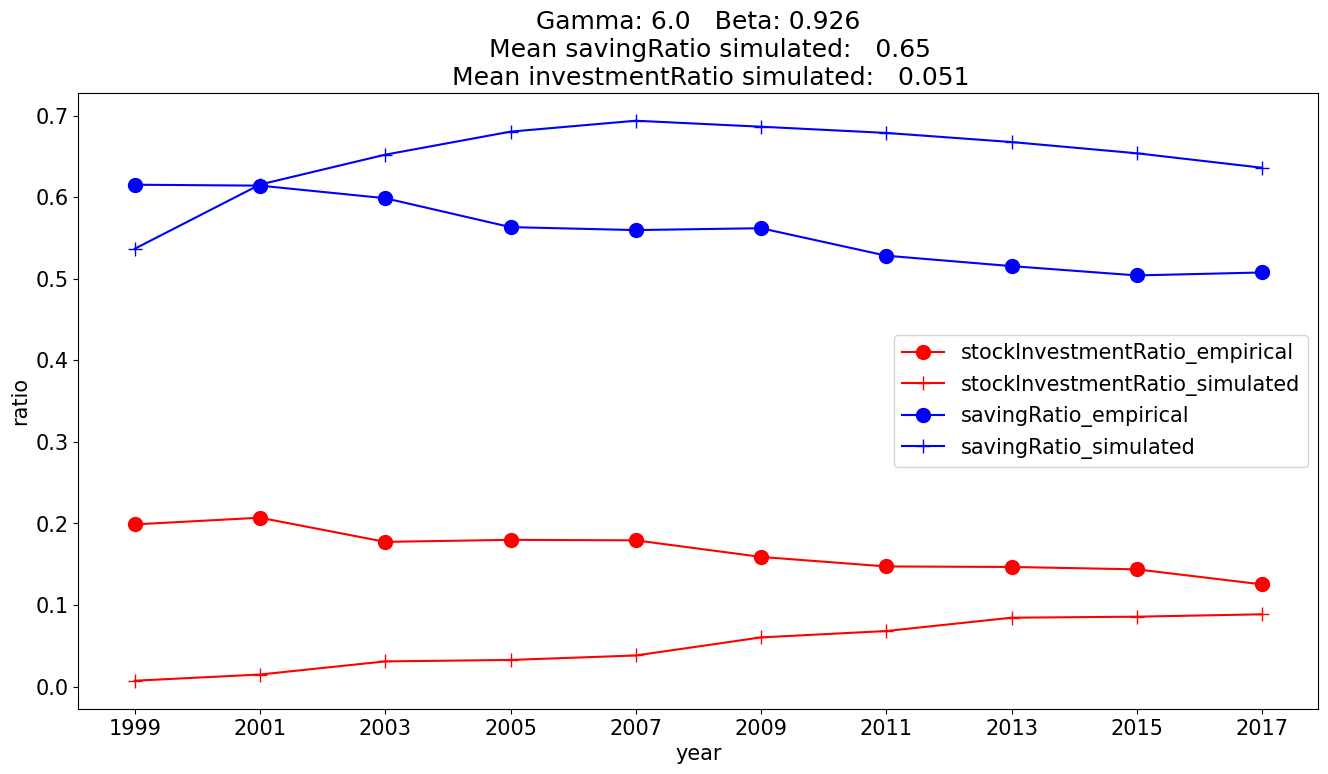

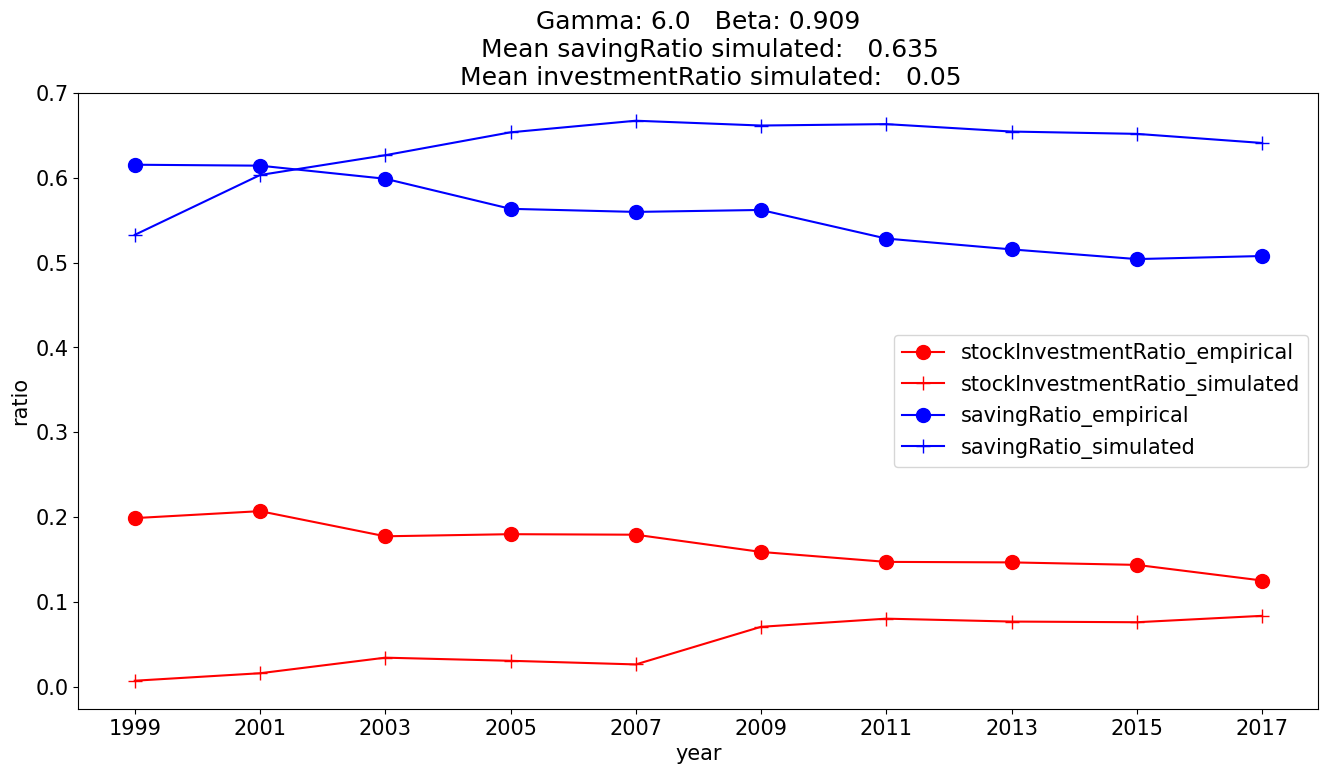

In [79]:
stockInvestmentRatioCollect = []
savingRatioCollect = []
stockInvestmentRatioCollectTrue = []
savingRatioCollectTrue = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        plt.figure()
        plt.xlabel("year")
        plt.xticks(years[:-1])
        plt.ylabel("ratio")
        stockRatio_empirical = []
        savingRatio_empirical = []
        stockRatio_simulated = []
        savingRatio_simulated = []
        for year in years[:-1]:
            # in that particular year and in that particular age group 
            df = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]
            # empirical stock investment ratio
            stockRatio_empirical.append((df.investmentAmount / (df.liquidWealth + df.investmentAmount)).mean()) 
            # empirical saving ratio 
            savingRatio_empirical.append(((df.investmentAmount + df.liquidWealth + df.laborIncome)/
                                          (df.laborIncome + df.liquidWealth + df.totalExpense + df.investmentAmount)).mean())
            w = wwww[year - years[0],:]
            b = bbbb[year - years[0],:]
            k = kkkk[year - years[0],:]
            c = cccc[year - years[0],:]
            h = cccc[year - years[0],:]
            o = oooo[year - years[0],:]
            balance = mmmm[year - years[0],:]
            stockRatio_simulated.append((k/(b+k+c+(1-o)*h*pr+ o*m*(balance>0))).mean())
            savingRatio_simulated.append((b+k).mean()/(c+(1-o)*h*pr+ o*m*(balance>0)+b+k).mean())
        meanSaving_empirical = round(np.mean(savingRatio_empirical), 3)
        meanInvestment_empirical = round(np.mean(stockRatio_empirical), 3)
        meanSaving_simulated = round(np.mean(savingRatio_simulated), 3)
        meanInvestment_simulated = round(np.mean(stockRatio_simulated), 3)
        plt.title("Gamma: " + str(gamma) +  "   Beta: " + str(round(1/(1+beta_r),3)) + 
                  "\n   Mean savingRatio simulated:   " + str(meanSaving_simulated) +
                  "\n   Mean investmentRatio simulated:   " + str(meanInvestment_simulated) 
                 )
        plt.plot(years[:-1], stockRatio_empirical, 'ro-', label = "stockInvestmentRatio_empirical", markersize = 10)
        # plt.axhline(y=0.25, color='r', linestyle='--', label = "target_stockRatio")
        plt.plot(years[:-1], stockRatio_simulated, 'r+-', label = "stockInvestmentRatio_simulated", markersize = 10)
        
        plt.plot(years[:-1], savingRatio_empirical, 'bo-', label = "savingRatio_empirical", markersize = 10)
        # plt.axhline(y=0.40, color='b', linestyle='--', label = "target_savingRatio")
        plt.plot(years[:-1], savingRatio_simulated, 'b+-', label = "savingRatio_simulated", markersize = 10)
        
        stockInvestmentRatioCollect.append(stockRatio_simulated)
        stockInvestmentRatioCollectTrue.append(stockRatio_empirical)
        savingRatioCollect.append(savingRatio_simulated)
        savingRatioCollectTrue.append(savingRatio_empirical)
        plt.legend()

In [80]:
def tsplot(x, y, lab, n=2, percentile_min=25, percentile_max=75, color='r', line_color='k'):
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = []
    perc2 = []
    meanValue = []
    medianValue = []
    for i in range(len(y)):
        perc1.append(np.percentile(y[i], percentile_min))
        perc2.append(np.percentile(y[i], percentile_max))
        meanValue.append(np.mean(y[i]))
        medianValue.append(np.median(y[i]))
    plt.plot(x, meanValue, color=line_color,label = lab)
    return plt.gca()

/tmp/ipykernel_1342702/3108972523.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tsplot(years,np.array(investmentStock) + np.array(bondOrcash),"liquidWealth_empirical")


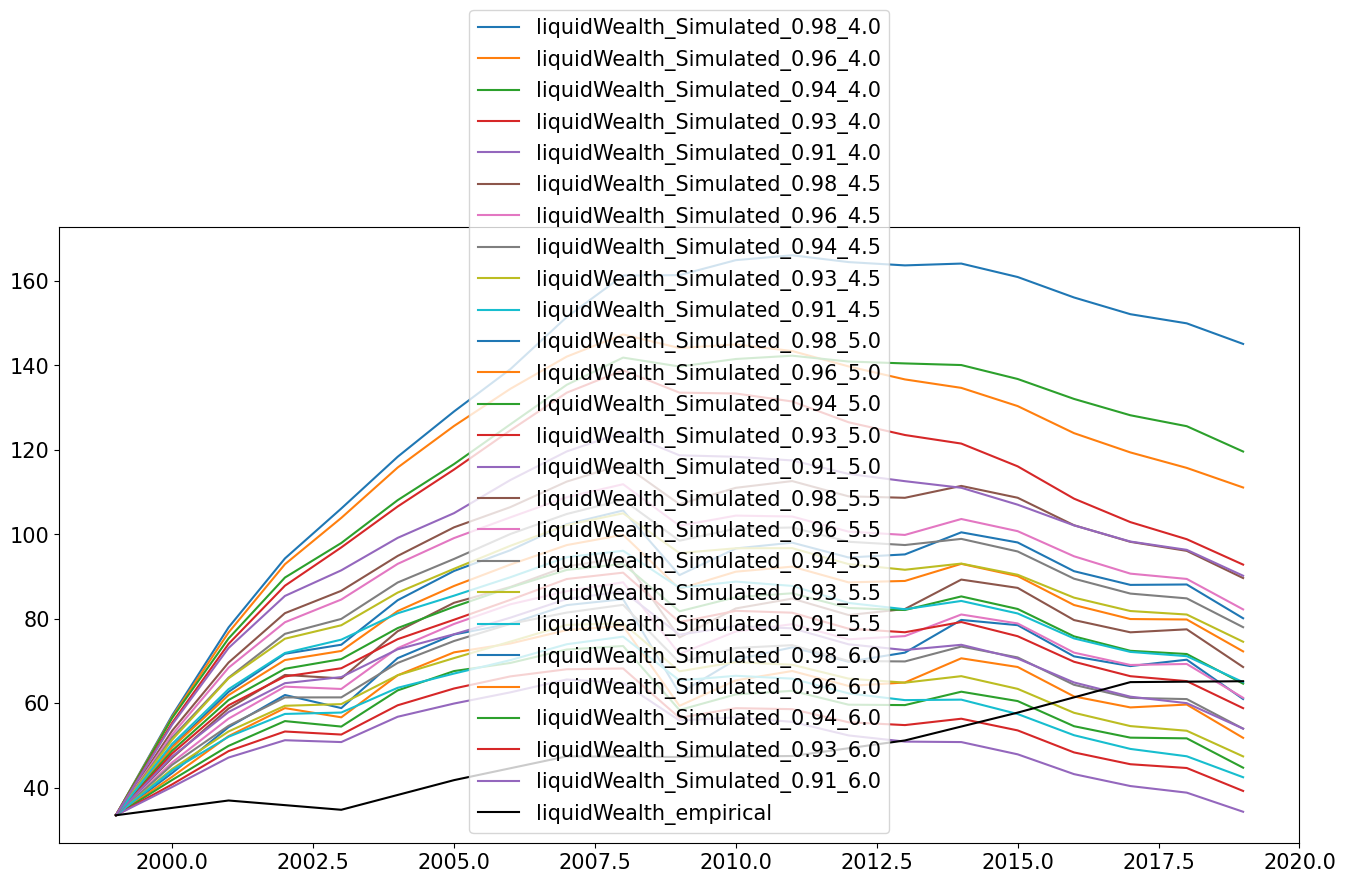

In [81]:
liquidWealthCollect = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r) 
        Label = "liquidWealth_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
        plt.plot(range(1999,2020), wwww.mean(axis = 1), label = Label)
        liquidWealthCollect.append(wwww.mean(axis = 1))
        
tsplot(years,np.array(investmentStock) + np.array(bondOrcash),"liquidWealth_empirical")
plt.legend()

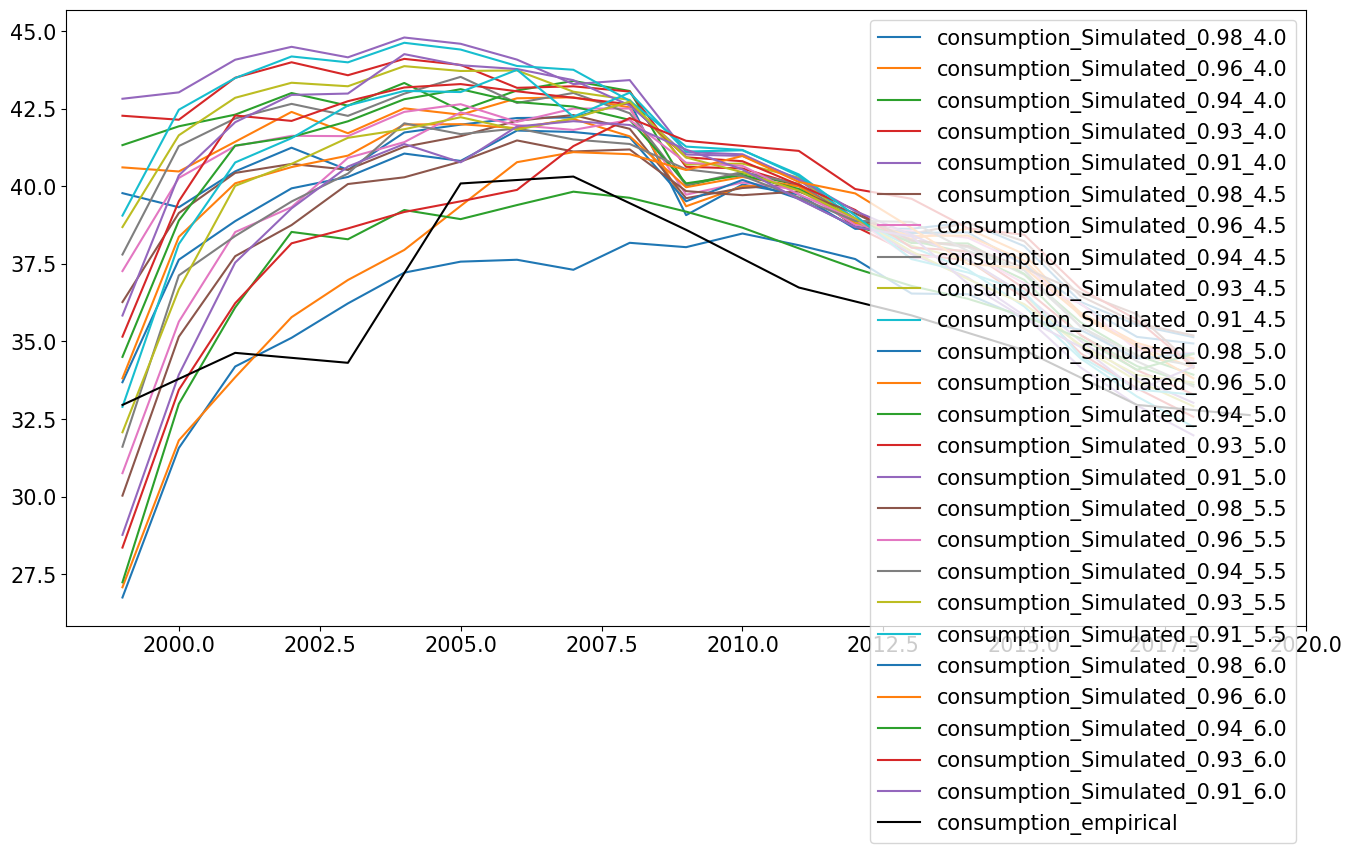

In [82]:
consumptionCollect = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        Label = "consumption_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
        plt.plot(range(1999,2019), cccc.mean(axis = 1), label = Label)
        consumptionCollect.append(cccc.mean(axis = 1))
tsplot(years,consumption, "consumption_empirical")
plt.legend()

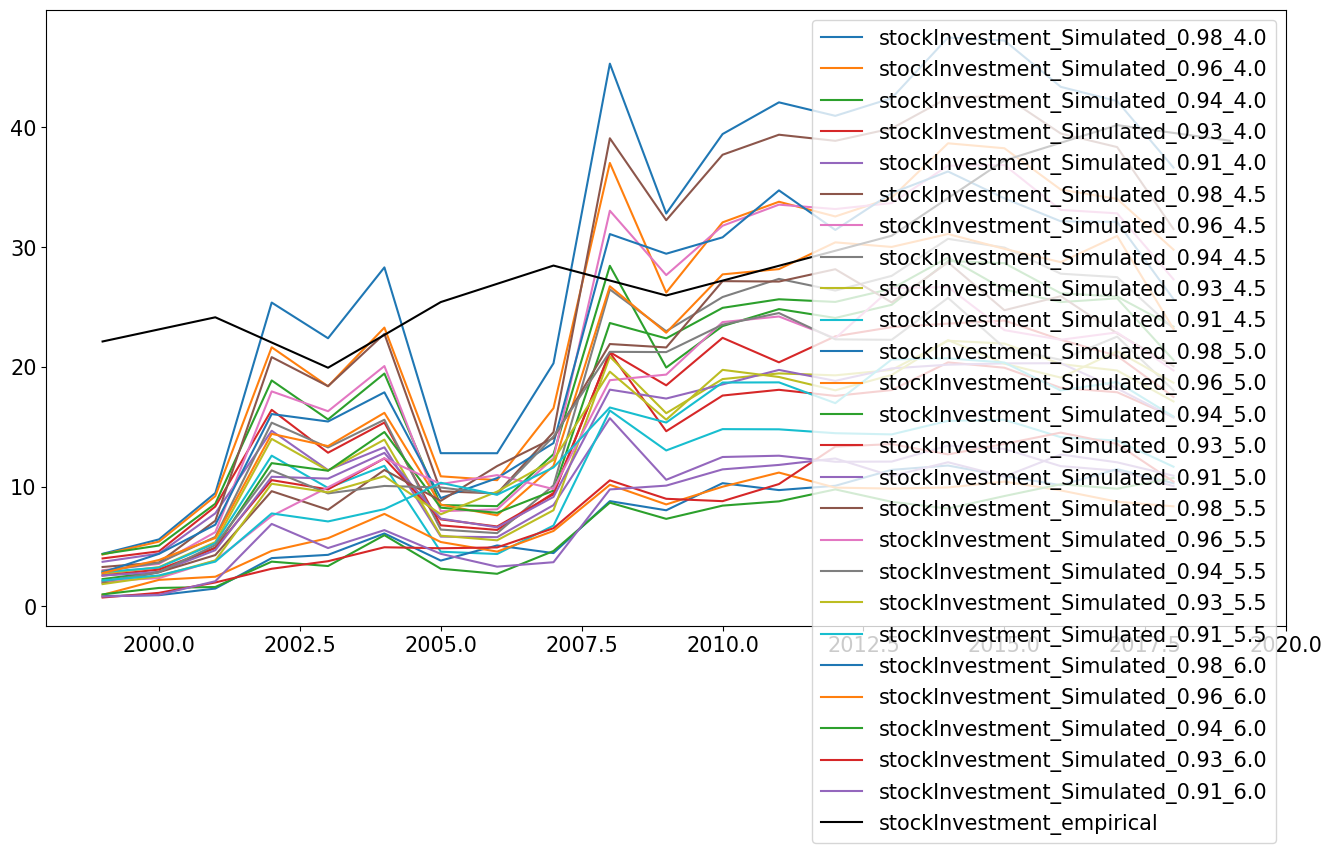

In [83]:
investmentAmountCollect = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        Label = "stockInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
        plt.plot(range(1999,2019), kkkk.mean(axis = 1), label = Label)
        investmentAmountCollect.append(kkkk.mean(axis = 1))
tsplot(years,investmentStock,"stockInvestment_empirical")
plt.legend()

/tmp/ipykernel_1342702/4156341624.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tsplot(years,np.array(bondOrcash) + np.array(laborIncome)/2,"bondInvestment_empirical", color = k)


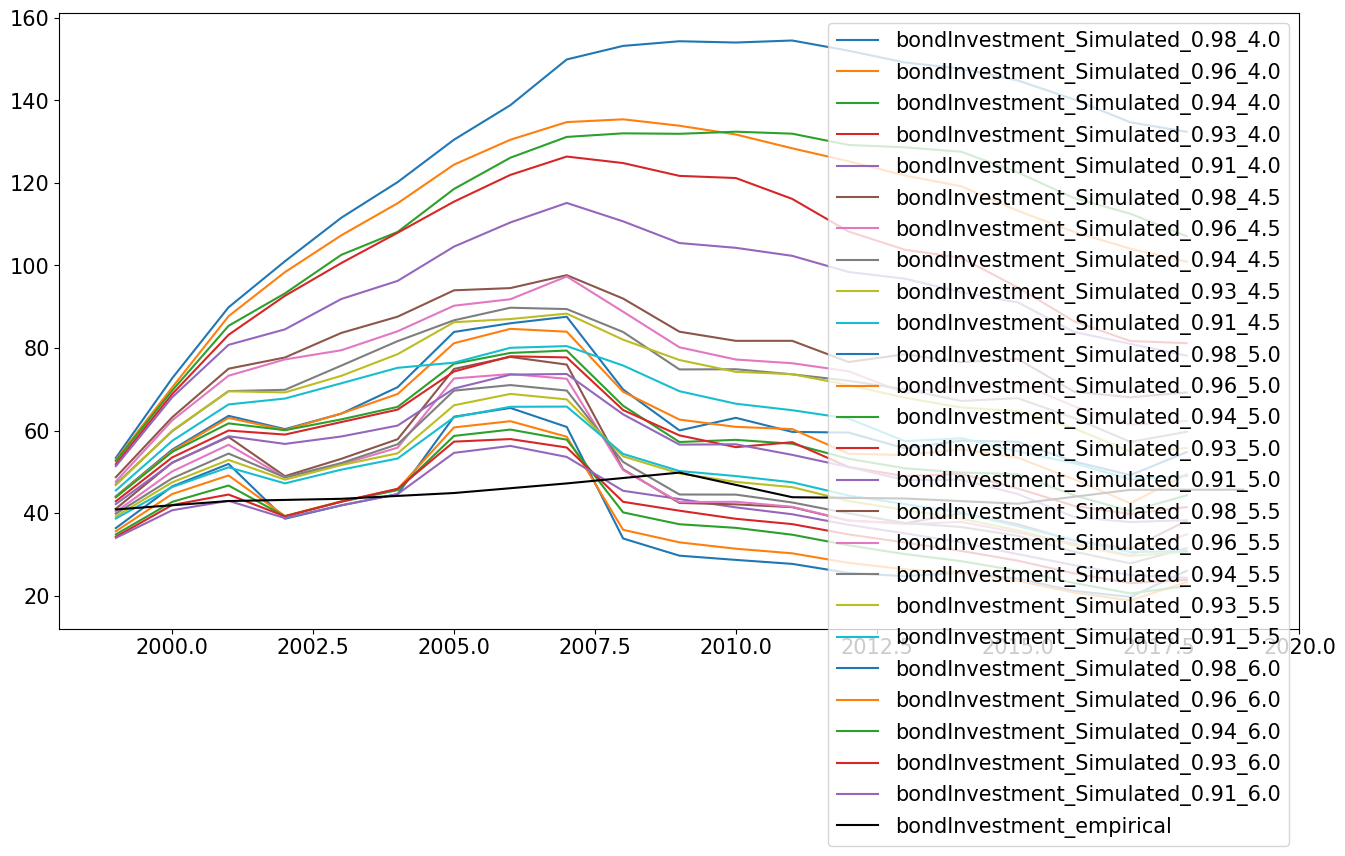

In [84]:
bondInvestmentCollect = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        Label = "bondInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma)
        plt.plot(range(1999,2019), bbbb.mean(axis = 1), label = Label)       
        bondInvestmentCollect.append(bbbb.mean(axis = 1))
tsplot(years,np.array(bondOrcash) + np.array(laborIncome)/2,"bondInvestment_empirical", color = k)
plt.legend()

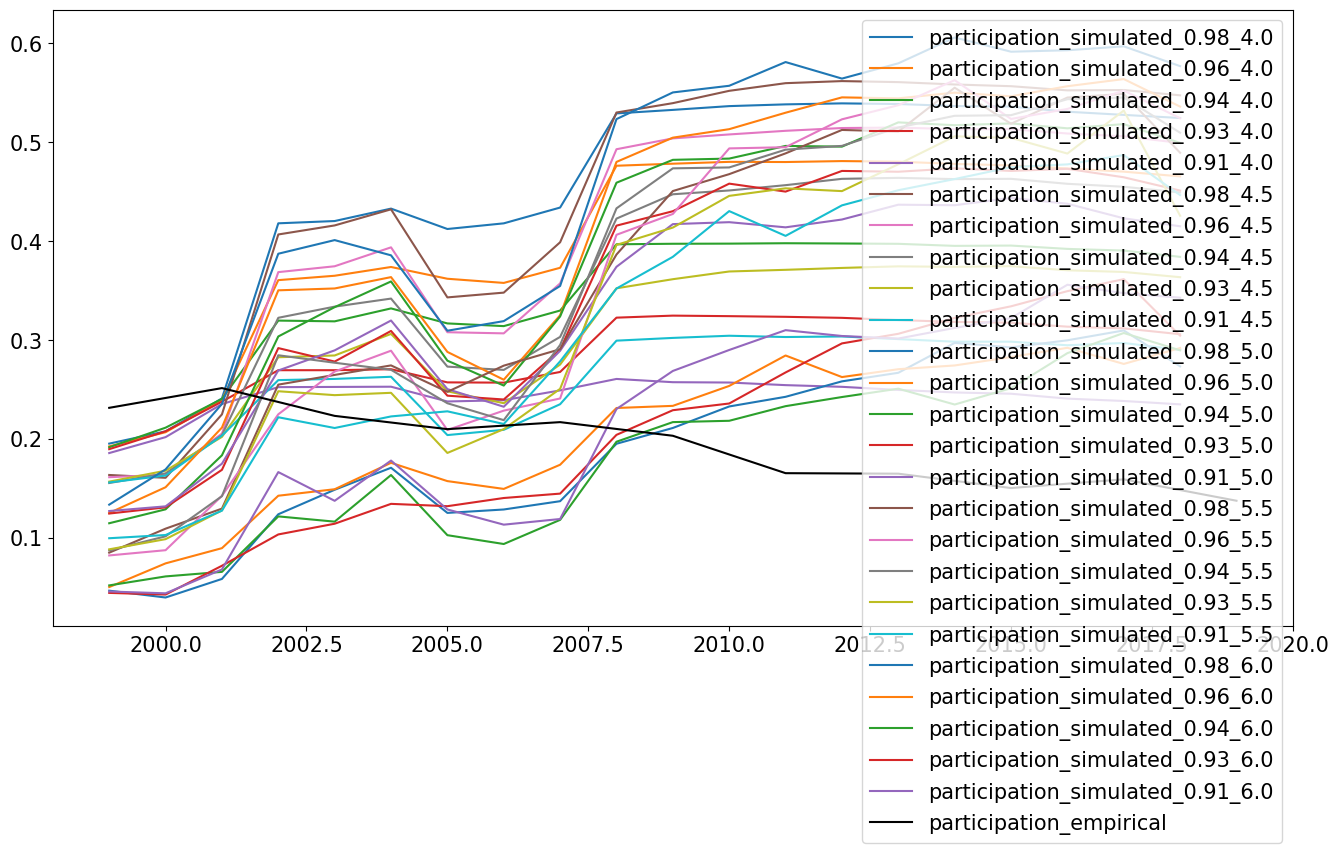

In [85]:
participationCollect = []
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        plt.plot(range(1999,2019), (kkkk>1).mean(axis = 1), label = "participation_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
        participationCollect.append((kkkk>1).mean(axis = 1))
plt.plot(years,participation_mean, label = "participation_empirical", color = "k")
plt.legend()

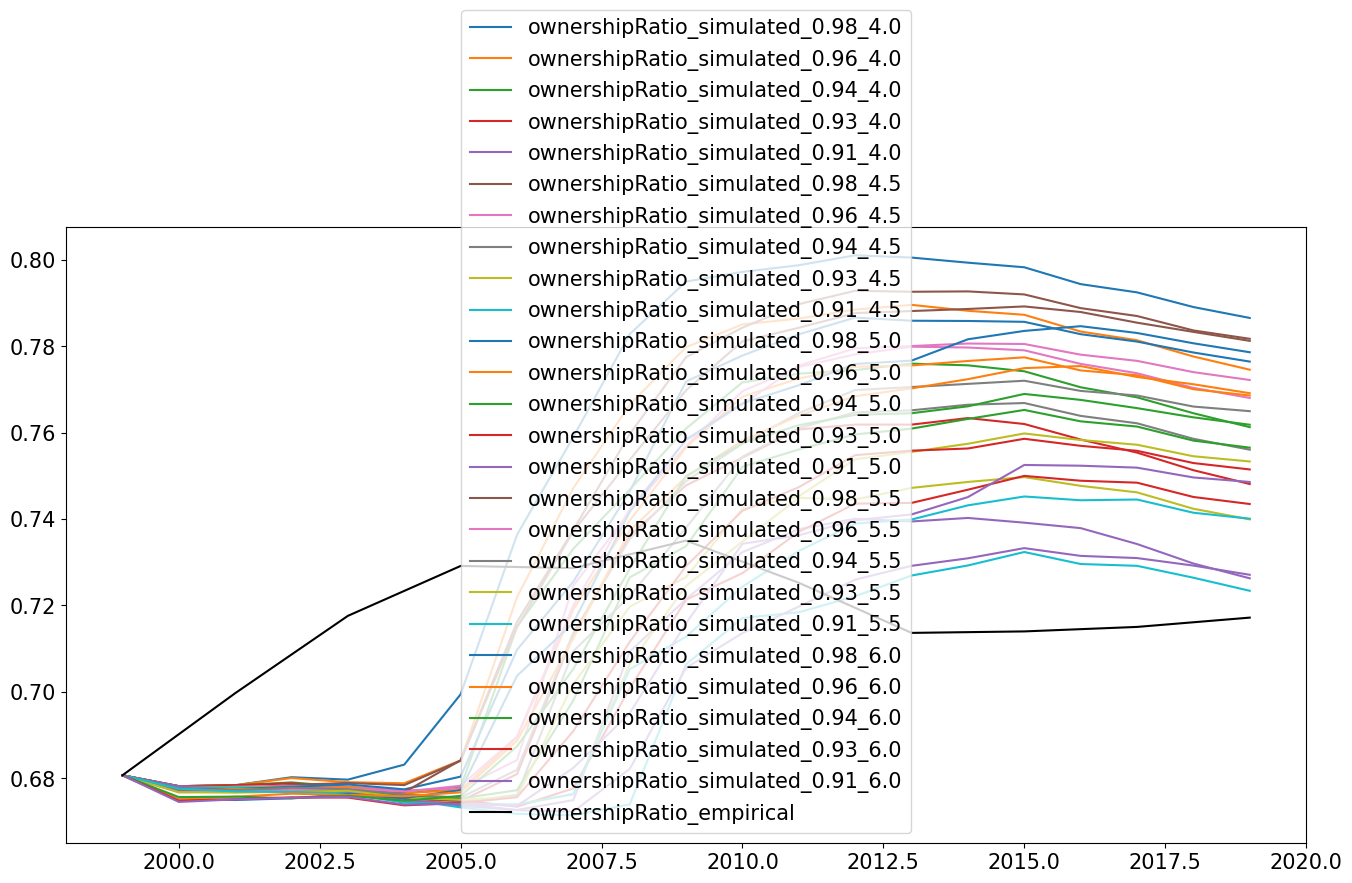

In [86]:
ownershipCollect =[]
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        plt.plot(range(1999,2020), (oooo).mean(axis = 1), label = "ownershipRatio_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
        ownershipCollect.append((oooo).mean(axis = 1))
plt.plot(years, ownershipStatus_mean, label = "ownershipRatio_empirical", color = "k")
plt.legend()

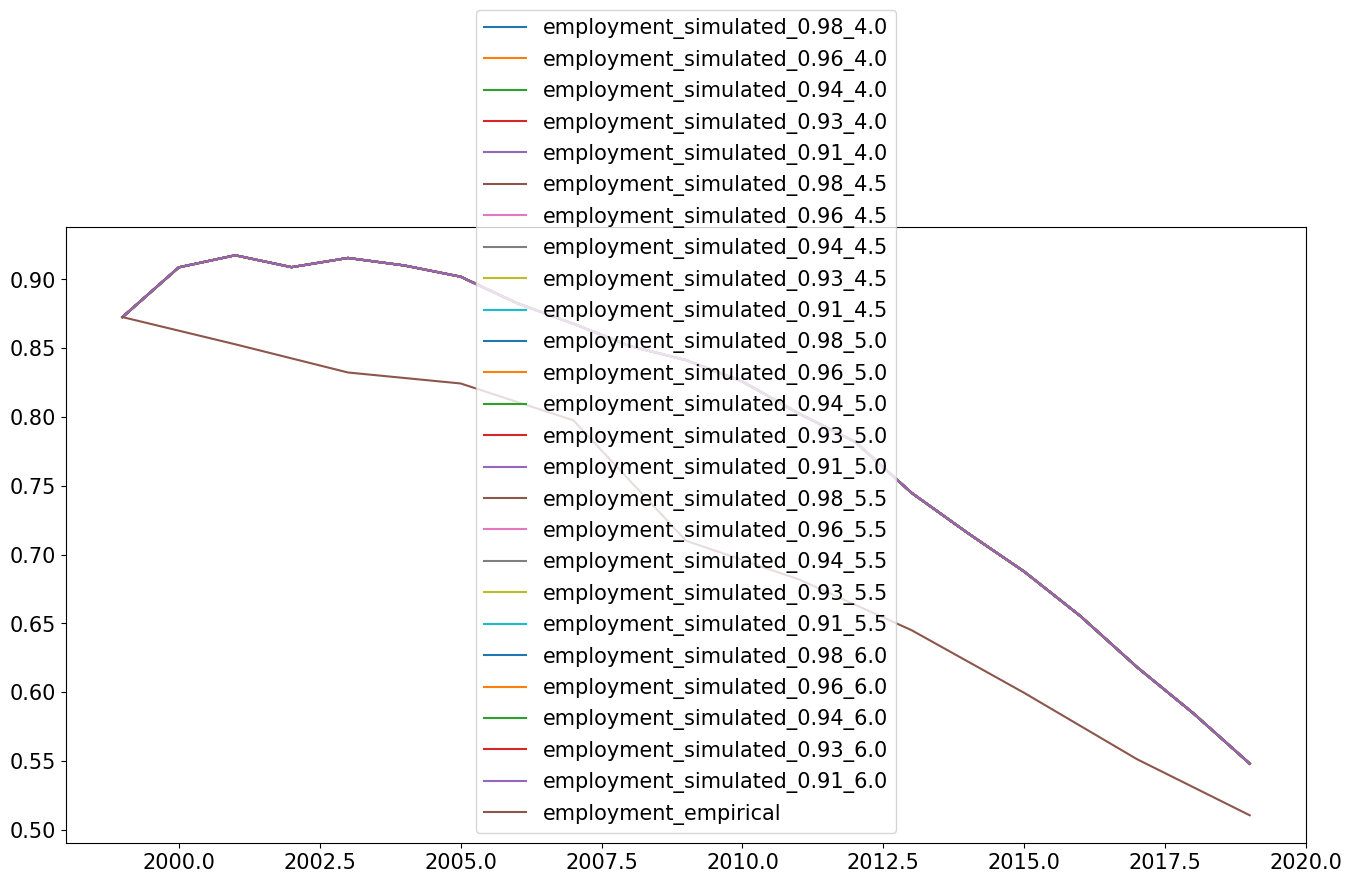

In [87]:
for gamma in Gamma:
    for beta_r in Beta_r:
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = variables(gamma, beta_r)
        plt.plot(range(1999,2020), eeee.mean(axis = 1), label = "employment_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
# fix here the retirment people is unemployed. 
plt.plot(years, employment_mean, label = "employment_empirical")
plt.legend()

### GMM 

In [88]:
# simulated results 
stockInvestmentRatioCollect = np.array(stockInvestmentRatioCollect)
savingRatioCollect = np.array(savingRatioCollect)
stockInvestmentRatioCollectE = np.array(stockInvestmentRatioCollectTrue[0])
savingRatioCollectE = np.array(savingRatioCollectTrue[0])
liquidWealthCollect = np.array(liquidWealthCollect)
consumptionCollect = np.array(consumptionCollect)
investmentAmountCollect = np.array(investmentAmountCollect)
bondInvestmentCollect = np.array(bondInvestmentCollect)
participationCollect = np.array(participationCollect)
ownershipCollect = np.array(ownershipCollect)


targetMean = np.array([savingRatioCollectE.mean(), stockInvestmentRatioCollectE.mean(), liquidWealth_mean.mean(), 
                        consumption_mean.mean(),
                        investmentStock_mean.mean(), 
                        (bondOrcash_mean + laborIncome_mean/2).mean(), 
                        0.45,
                        np.mean(ownershipStatus_mean)])

empriricalMean = [savingRatioCollect, stockInvestmentRatioCollect, liquidWealthCollect, 
                    consumptionCollect, investmentAmountCollect, bondInvestmentCollect,
                     participationCollect, ownershipCollect]

optimalBetas = []
optimalGammas = []
Beta_r = [0.02,0.04,0.06,0.08,0.10]
Gamma = [4.0, 4.5, 5.0, 5.5, 6.0]
BetaGamma = [[b,r] for r in Gamma for b in Beta_r ]

for weightsIndex in range(2,8):
    weights = np.ones(len(targetMean))/len(targetMean)
    # making participation and ownership more important
    #weights[weightsIndex] = 2
    errors = []
    for i in range(len(Beta_r)*len(Gamma)):
        matchMean = np.zeros(len(targetMean))
        for j in range(len(targetMean)):
            if j >=2 and j <= 5:
                matchMean[j] = ((empriricalMean[j][i] - targetMean[j])/np.std((empriricalMean[j][i] - targetMean[j]))).mean()
        errors.append(np.dot(weights, matchMean*matchMean))
    beta_opt, gamma_opt = BetaGamma[np.argmin(errors)]
    print("Beta Value: ", 1 / (1 + beta_opt))
    print("Gamma Value: ", gamma_opt)

    optimalBetas.append(beta_opt)
    optimalGammas.append(gamma_opt)

Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0
Beta Value:  0.9615384615384615
Gamma Value:  4.0


In [89]:
i = BetaGamma.index([0.02, 4.0])

matchMean = np.zeros(len(targetMean))
for j in range(len(targetMean)):
        matchMean[j] = empriricalMean[j][i].mean() 

alternativeMatchMeanCollect = []
for b,g in zip(optimalBetas, optimalGammas):
        i = BetaGamma.index([b, g])
        alternativeMatchMean = np.zeros(len(targetMean))
        for j in range(len(targetMean)):
                alternativeMatchMean[j] = empriricalMean[j][i].mean() 
        alternativeMatchMeanCollect.append(np.round(alternativeMatchMean, 2))

In [90]:
data = {'variables':['savingRatio', 'stockInvestmentRatio', 'liquidWealth', 
                        'consumption', 'stockInvestmentAmount', 'bondInvestmentAmount',
                        'participationRatio','ownershipRatio'],
        'empiricalMeanValue':np.round(targetMean, 2),
        'simulatedMeanValue':np.round(matchMean, 2),
        }
pd.DataFrame(data)

variables  empiricalMeanValue  simulatedMeanValue
0            savingRatio                0.56                0.53
1   stockInvestmentRatio                0.17                0.17
2           liquidWealth               48.01               67.74
3            consumption               35.80               39.61
4  stockInvestmentAmount               29.24               30.06
5   bondInvestmentAmount               44.54               36.80
6     participationRatio                0.45                0.45
7         ownershipRatio                0.72                0.75

In [91]:
def simulatedPlot(value, title, targetValue = None, targetValues = None):
    plt.figure()
    plt.title(title)
    plt.xticks(years)
    upperBound = value.max(axis = 0)
    lowerBound = value.min(axis = 0)
    if len(lowerBound) == 10:
        #plt.fill_between(range(1999, 2019, 2), lowerBound, upperBound)
        plt.plot(range(1999, 2019, 2),value[i], color = "b", label = "simulated")
    elif len(lowerBound) == 20:
        #plt.fill_between(range(1999, 2019), lowerBound, upperBound)
        plt.plot(range(1999, 2019),value[i], color = "b", label = "simulated")
    else:
        #plt.fill_between(range(1999, 2020), lowerBound, upperBound)
        plt.plot(range(1999, 2020),value[i], color = "b", label = "simulated")
    if(np.isscalar(targetValue)):
        plt.axhline(targetValue, color = "r")
    elif(len(targetValue)==10):
        plt.plot(range(1999, 2019, 2), targetValue, color = "r", label = "empirical") 
    else:
        plt.plot(years, targetValue, color = "r", label = "empirical") 
    plt.legend()
    plt.show()

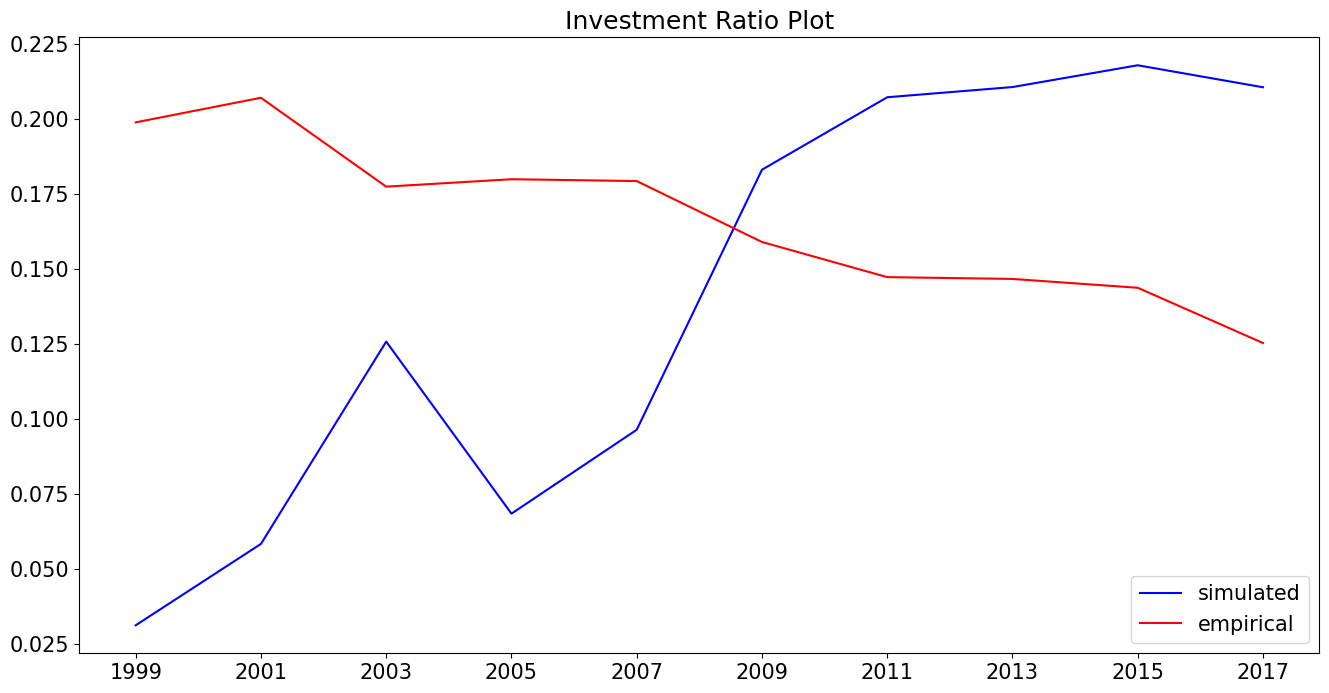

In [92]:
simulatedPlot(stockInvestmentRatioCollect, targetValue = stockInvestmentRatioCollectE, title = "Investment Ratio Plot")

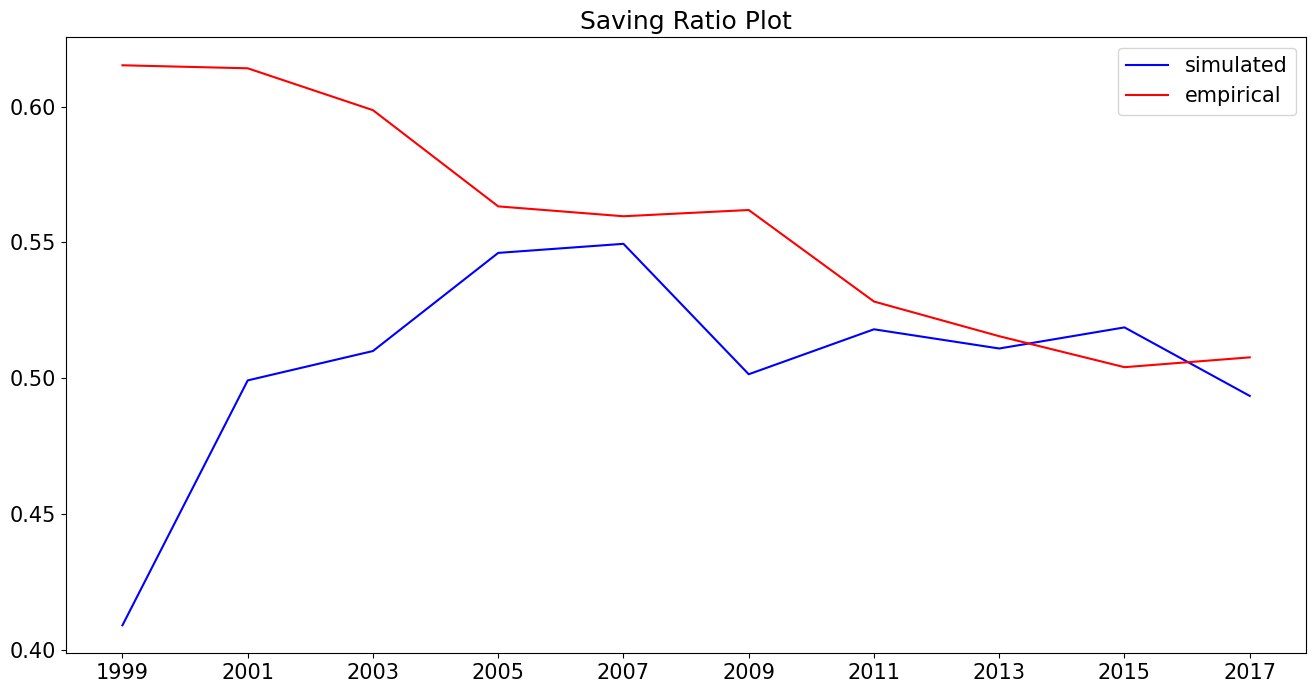

In [93]:
simulatedPlot(savingRatioCollect, targetValue = savingRatioCollectE, title = "Saving Ratio Plot")

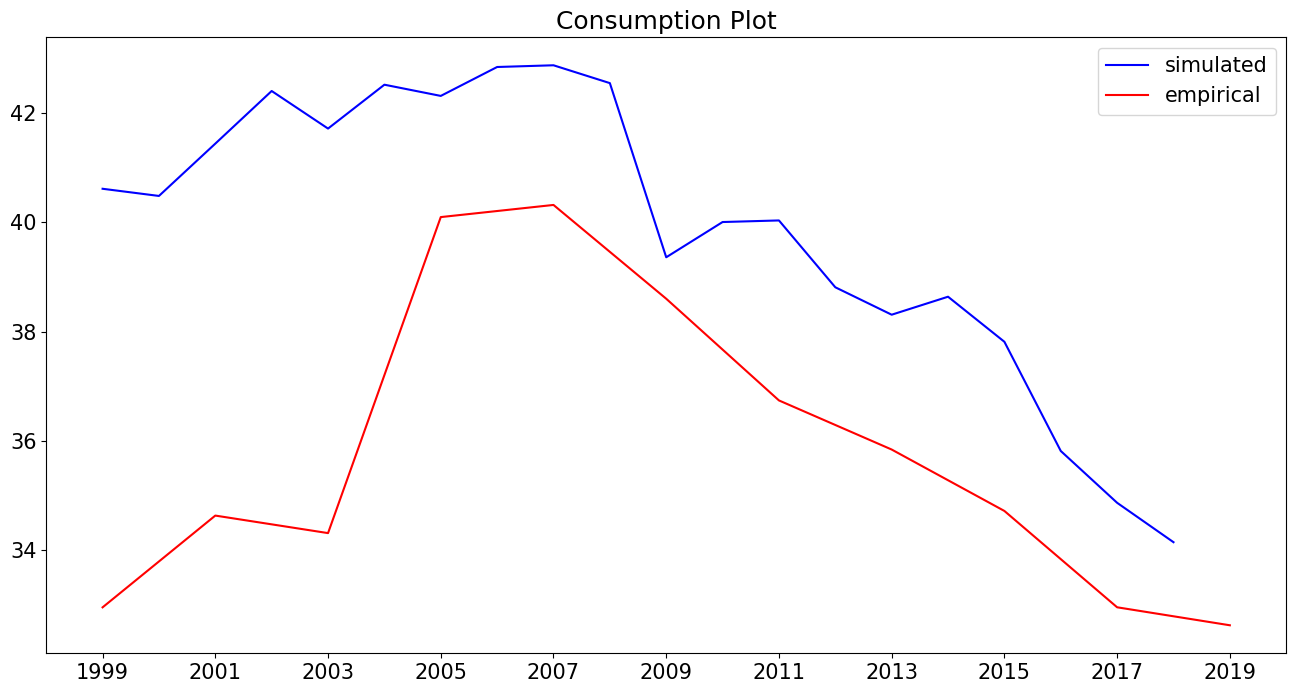

In [94]:
simulatedPlot(consumptionCollect, targetValue = consumption_mean, title = "Consumption Plot")

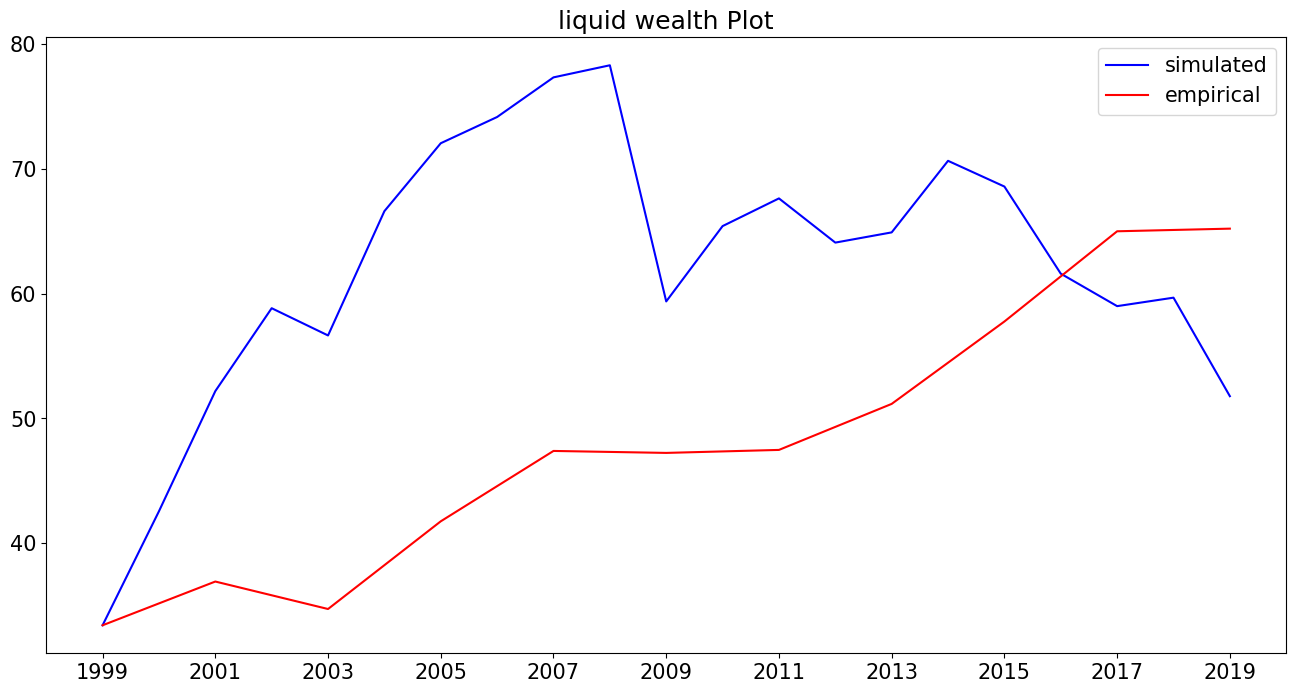

In [95]:
simulatedPlot(liquidWealthCollect, targetValue = liquidWealth_mean, title = "liquid wealth Plot")

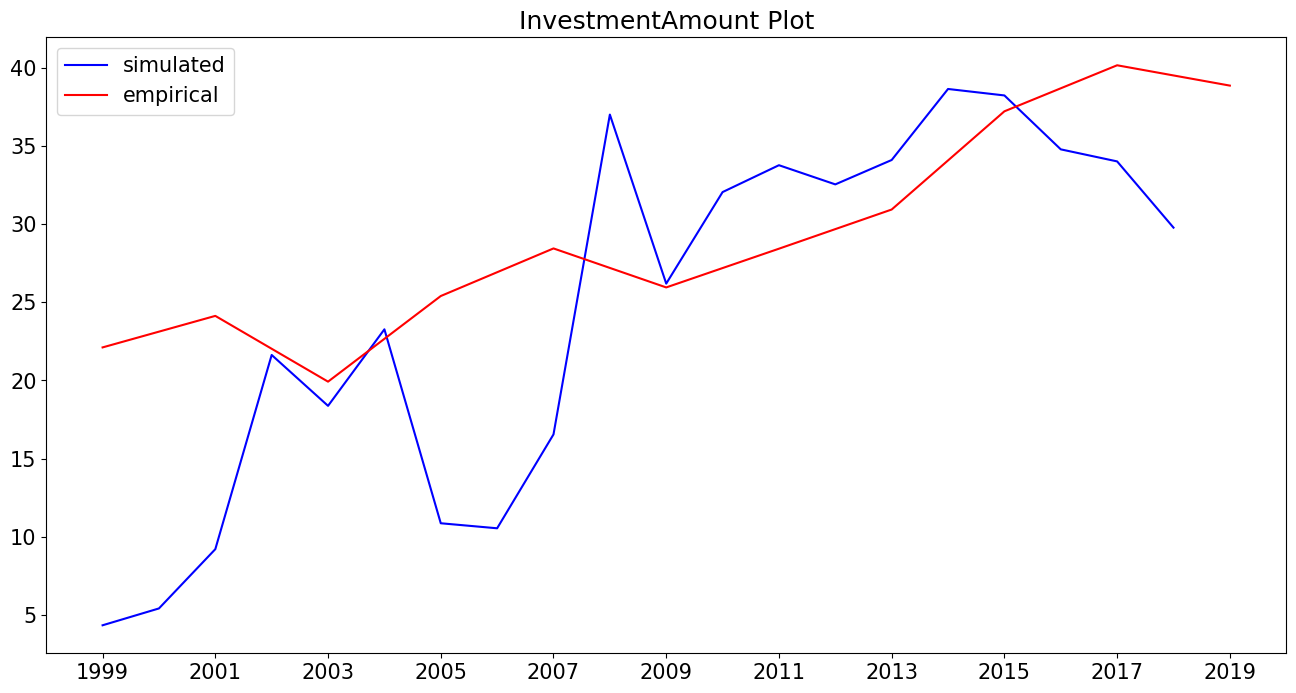

In [96]:
simulatedPlot(investmentAmountCollect, targetValue = investmentStock_mean, title = "InvestmentAmount Plot")

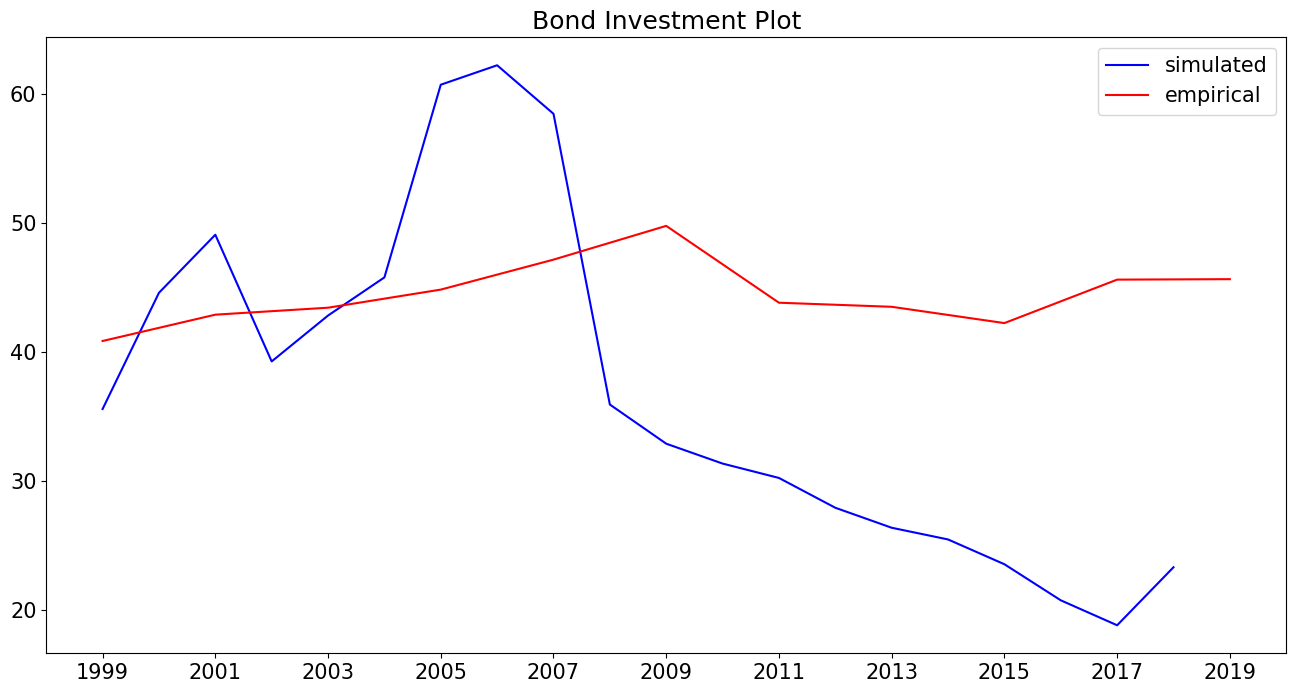

In [97]:
simulatedPlot(bondInvestmentCollect, targetValue = bondOrcash_mean + laborIncome_mean/2, title = "Bond Investment Plot")

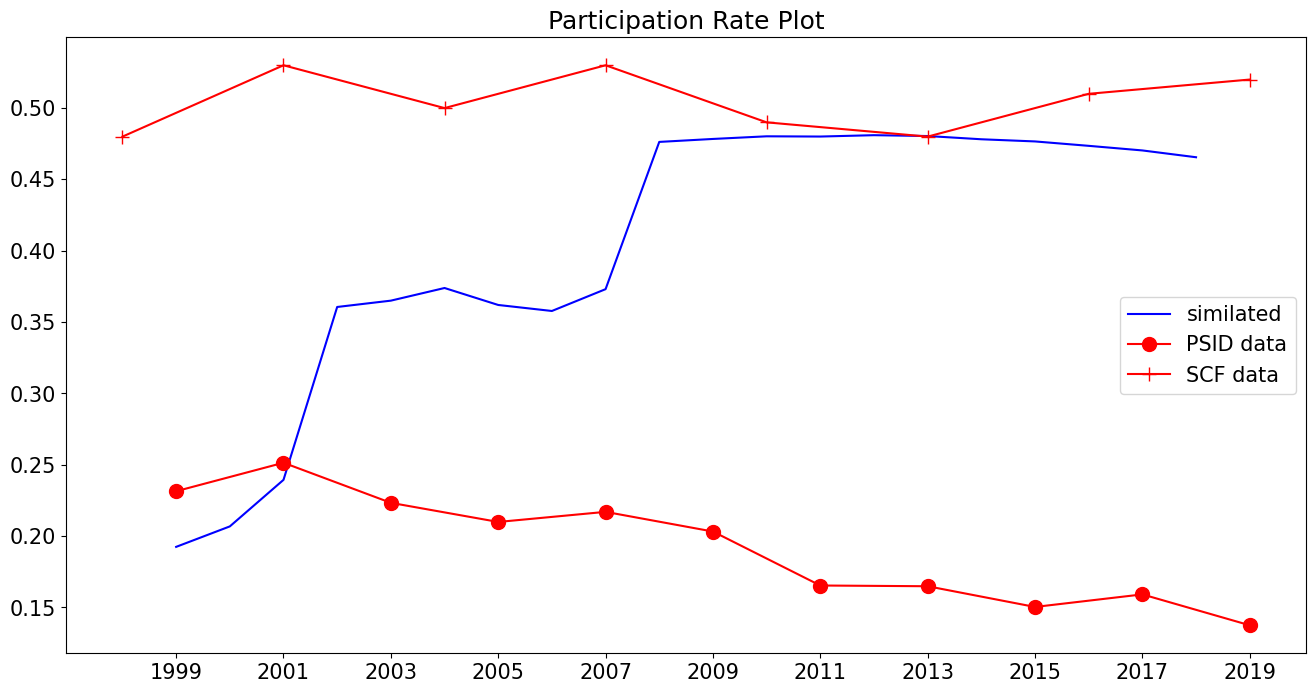

In [98]:
value = participationCollect
targetValue = participation_mean
title = "Participation Rate Plot"
plt.figure()
plt.title(title)
plt.xticks(years)
upperBound = value.max(axis = 0) 
lowerBound = value.min(axis = 0)
if len(lowerBound) == 10:
    #plt.fill_between(range(1999, 2019, 2), lowerBound, upperBound)
    plt.plot(range(1999, 2019, 2),value[i], color = "b", label = "similated")
elif len(lowerBound) == 20:
    #plt.fill_between(range(1999, 2019), lowerBound, upperBound)
    plt.plot(range(1999, 2019),value[i], color = "b", label = "similated")
else:
    #plt.fill_between(range(1999, 2020), lowerBound, upperBound)
    plt.plot(range(1999, 2020),value[i], color = "b", label = "similated")
if(len(targetValue)==10):
    plt.plot(range(1999, 2019, 2), targetValue, "ro-",markersize = 10, label = "PSID data")
else:
    plt.plot(years, targetValue, "ro-",markersize = 10, label = "PSID data")  

scfDatayear = np.array([1998,2001,2004,2007,2010,2013,2016,2019])
scfDataP = np.array([0.48, 0.53, 0.50,0.53,0.49,0.48,0.51,0.52])
plt.plot(scfDatayear, scfDataP, "r+-", label = "SCF data", markersize = 10)
plt.legend()

In [105]:
AgentType

['poorHigh', 'poorLow', 'richHigh', 'richLow']

### cross age simulation 

In [121]:
AgentType = ['poorHigh','richLow', 'richHigh', 'poorLow']

In [ ]:
Beta_r = [0.02]
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean wealth level")
            plt.ylabel("value")
            plt.xlabel("age")
            plt.plot(range(startAge, T_max + startAge+1),np.mean(wwww,axis = 1), label = "wealth " + fileName)
plt.legend()

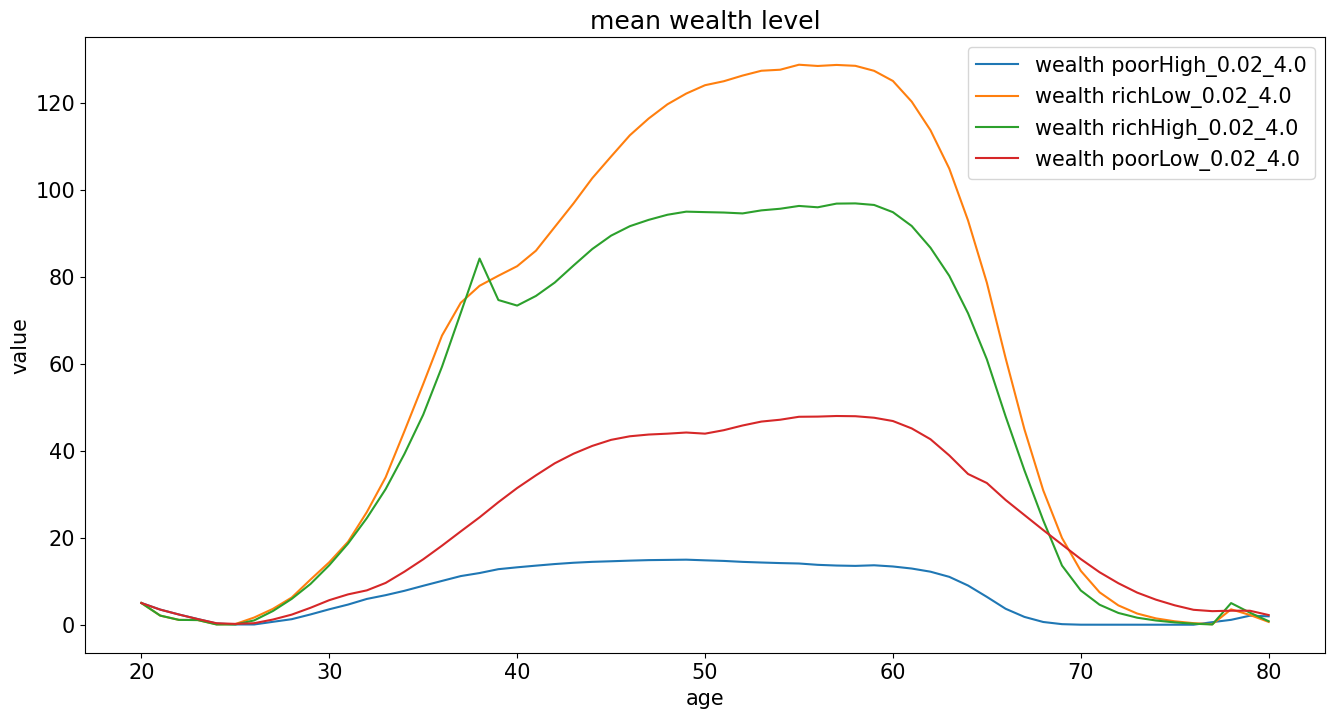

In [122]:
from matplotlib import pyplot as plt


T_max = 60
# housing unit
H = 1000
# housing price constant 
pt = 2*250/1000
Gamma = [4.0]
Beta_r = [0.02]
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean wealth level")
            plt.ylabel("value")
            plt.xlabel("age")
            plt.plot(range(startAge, T_max + startAge+1),np.mean(wwww,axis = 1), label = "wealth " + fileName)
plt.legend()
plt.savefig("plots/meanWealthLevel.jpg")

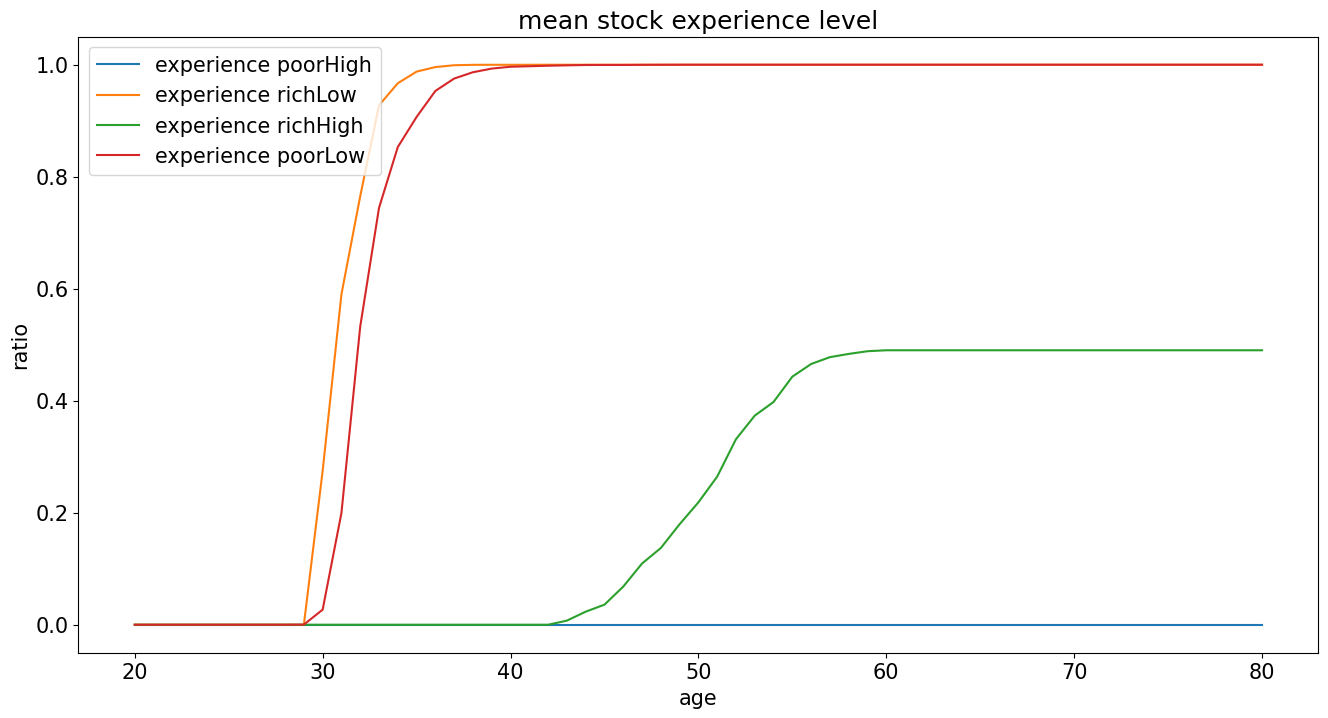

In [123]:
plt.figure()
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean stock experience level")
            plt.ylabel("ratio")
            plt.xlabel("age")
            plt.plot(range(startAge, T_max + startAge+1),np.mean(zzzz,axis = 1), label = "experience " + agentType)
plt.legend()
plt.savefig("plots/meanStockExperienceLevel.jpg")

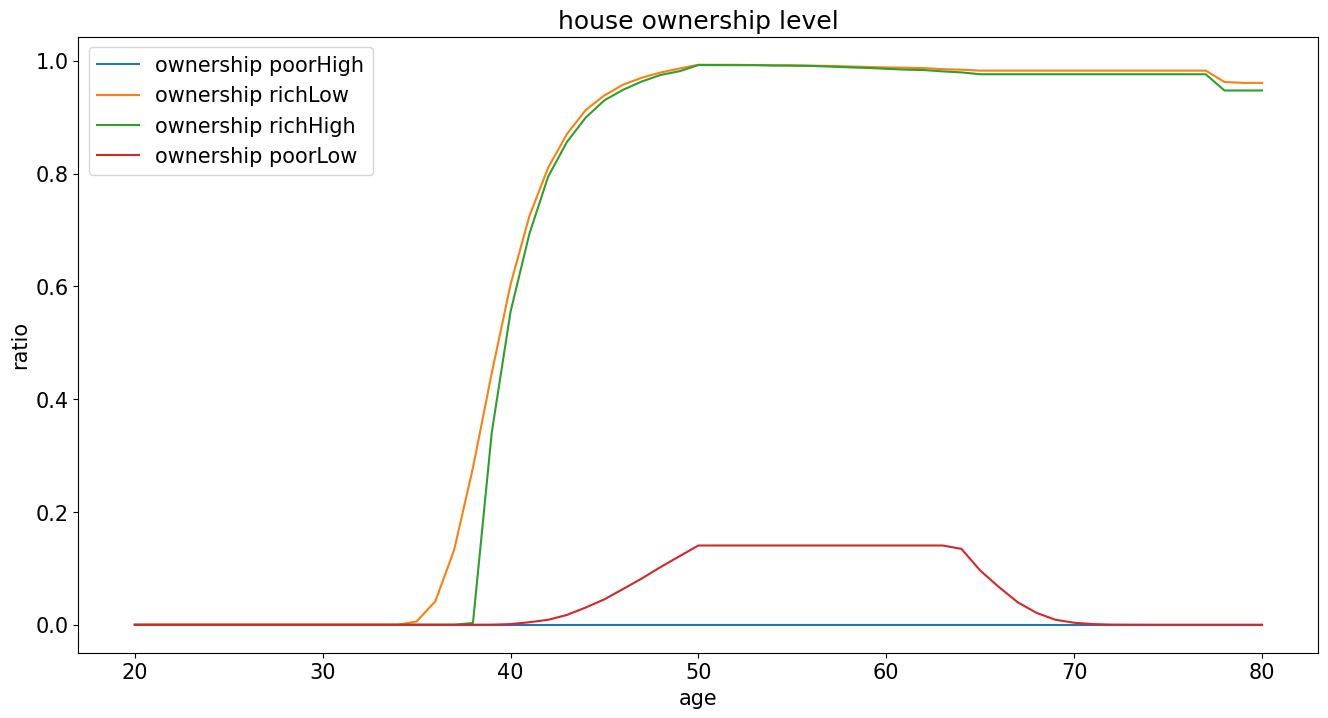

In [124]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("house ownership level")
            plt.ylabel("ratio")
            plt.xlabel("age")
            plt.plot(range(startAge, T_max + startAge+1),np.mean(oooo,axis = 1), label = "ownership " + agentType)
plt.legend()
plt.savefig("plots/meanHouseOwnership.jpg")

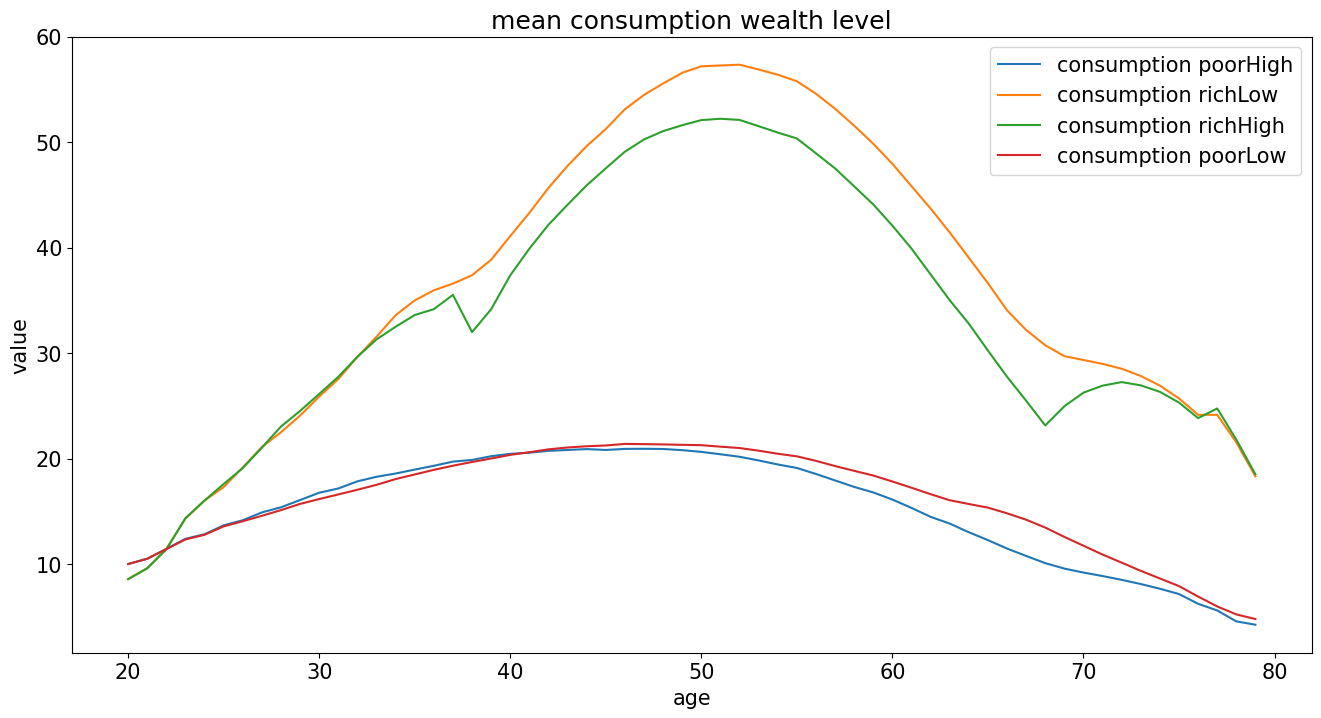

In [125]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean consumption wealth level")
            plt.ylabel("value")
            plt.xlabel("age")
            plt.plot(range(startAge, T_max + startAge),np.mean(cccc,axis = 1), label = "consumption " + agentType)
plt.legend()
plt.savefig("plots/meanConsumption.jpg")

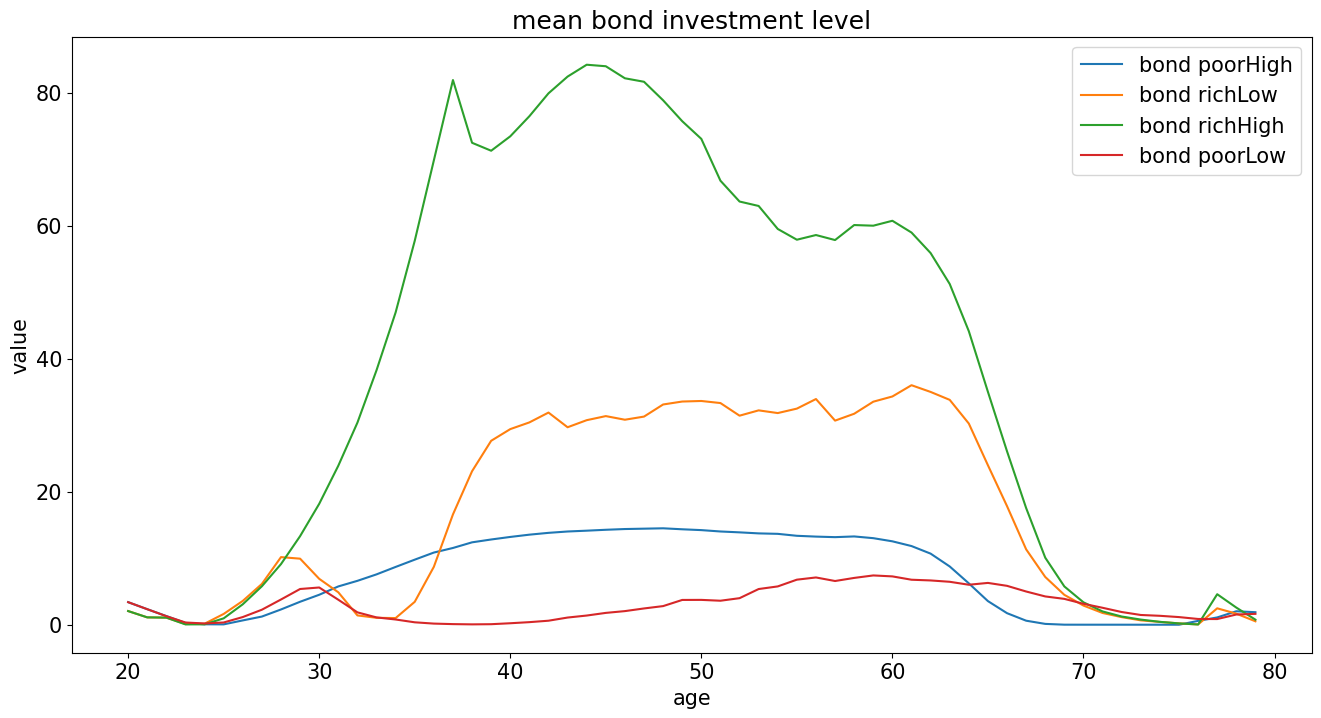

In [126]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean bond investment level")
            plt.ylabel("value")
            plt.xlabel("age")
            plt.plot(range(startAge, T_max + startAge),np.mean(bbbb,axis = 1), label = "bond " + agentType)
plt.legend()
plt.savefig("plots/meanBond.jpg")

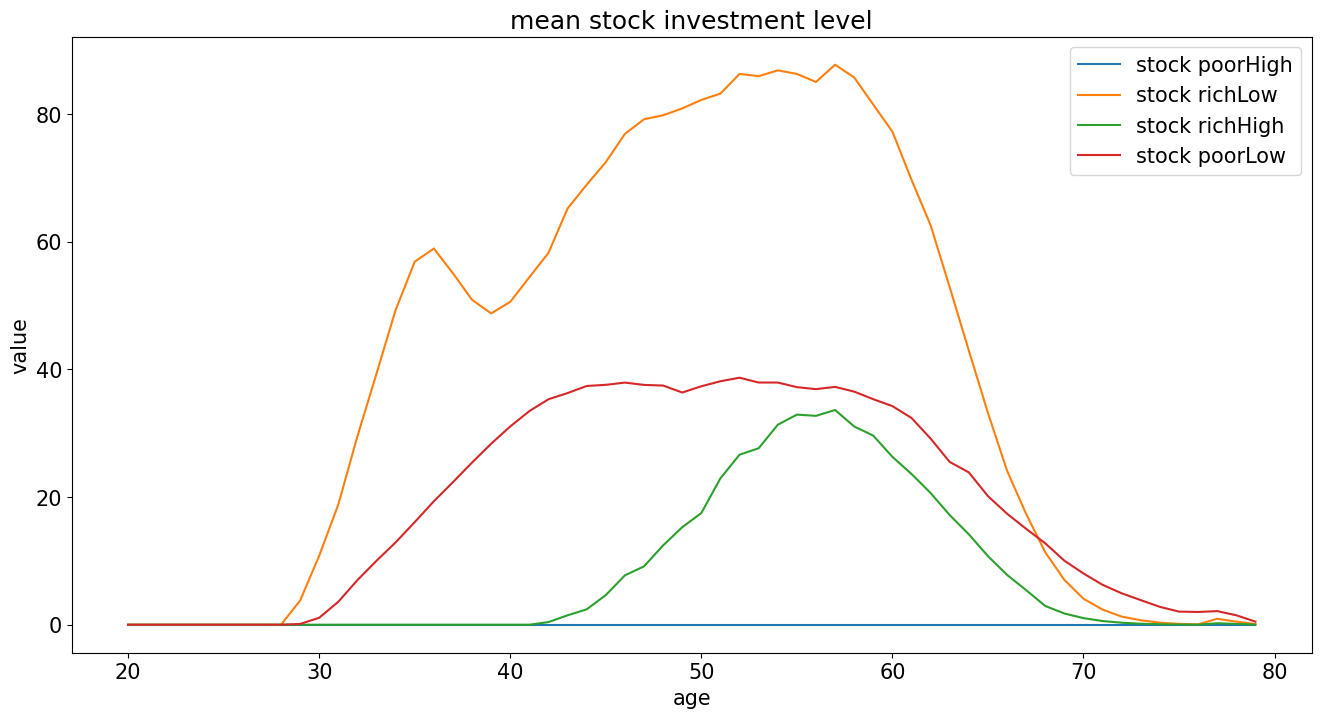

In [127]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhm = np.load("solution/parallel_waseozcbkhm_" + fileName + ".npy", allow_pickle=True)
            # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
            wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
            startAge = 20
            # value of states, state has one more value, since the terminal state does not have associated action
            plt.title("mean stock investment level")
            plt.ylabel("value")
            plt.xlabel("age")
            plt.plot(range(startAge, T_max + startAge),np.mean(kkkk,axis = 1), label = "stock " + agentType)
plt.legend()
plt.savefig("plots/meanStock.jpg")